In [7]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Definir transformações e DataLoader
class DataLoaderSetup:
    def __init__(self, dataset_path, image_size=224, batch_size=32):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.batch_size = batch_size

    def get_transforms(self):
        transformacoes_de_imagens = {
            'treino': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'validacao': transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.CenterCrop(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return transformacoes_de_imagens

    def load_data(self):
        transformacoes = self.get_transforms()
        pasta_treino = os.path.join(self.dataset_path, 'treino')
        pasta_validacao = os.path.join(self.dataset_path, 'validacao')

        data = {
            'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes['treino']),
            'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes['validacao'])
        }
        return data

    def get_data_loaders(self):
        data = self.load_data()
        data_loader_treino = DataLoader(data['treino'], batch_size=self.batch_size, shuffle=True)
        data_loader_validacao = DataLoader(data['validacao'], batch_size=self.batch_size, shuffle=True)
        return data_loader_treino, data_loader_validacao, len(data['treino']), len(data['validacao']), len(data['treino'].classes)

# Classe para o modelo
class CustomResNet50:
    def __init__(self, num_classes):
        self.model = models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False  # Congelar as camadas
        for param in self.model.layer4.parameters():  # Descongelar o bloco "layer4"
            param.requires_grad = True

        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def get_model(self):
        return self.model
    
    
class CustomResNet152:
    def __init__(self, num_classes):
        self.model = models.resnet152(pretrained=True)  # Usando ResNet-152
        
        # Congelar todas as camadas
        for param in self.model.parameters():
            param.requires_grad = False  

        # Descongelar as camadas do bloco "layer4"
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Substituir a camada totalmente conectada (fc)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def get_model(self):
        return self.model


class Trainer:
    def __init__(self, model, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience=5, nameModel='model.pt'):
        self.model = model
        self.data_loader_treino = data_loader_treino
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_treino = num_imagens_treino
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.funcao_erro = nn.CrossEntropyLoss()
        self.otimizador = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.otimizador, mode='min', factor=0.1, patience=3, verbose=True)
        self.patience = patience
        self.nameModel = nameModel

    def treinar_e_validar(self, epocas):
        historico = []
        melhor_acuracia = 0.0
        early_stop_counter = 0

        for epoca in range(epocas):
            inicio_epoca = time.time()
            print(f"\n\nÉpoca: {epoca + 1}/{epocas}")
            erro_treino, acuracia_treino = self.executar_fase('treino')
            erro_validacao, acuracia_validacao, predicoes_validacao, labels_validacao = self.executar_fase('validacao', return_predictions=True)

            fim_epoca = time.time()
            print(f"Época {epoca + 1}/{epocas}, Treino: Erro: {erro_treino:.4f}, Acurácia: {acuracia_treino * 100:.2f}%, "
                  f"Validação: Erro: {erro_validacao:.4f}, Acurácia: {acuracia_validacao * 100:.2f}%, Tempo: {fim_epoca - inicio_epoca:.2f}s")

            historico.append([erro_treino, erro_validacao, acuracia_treino, acuracia_validacao])
            self.scheduler.step(erro_validacao)

            # Early stopping
            if acuracia_validacao > melhor_acuracia:
                melhor_acuracia = acuracia_validacao
                torch.save(self.model.state_dict(), self.nameModel)
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= self.patience:
                print("Parando o treinamento devido ao early stopping.")
                break

        # Calcular métricas finais
        self.calcular_metricas(predicoes_validacao, labels_validacao)
        return historico

    def executar_fase(self, fase, return_predictions=False):
        if fase == 'treino':
            self.model.train()
            data_loader = self.data_loader_treino
            num_imagens = self.num_imagens_treino
        else:
            self.model.eval()
            data_loader = self.data_loader_validacao
            num_imagens = self.num_imagens_validacao

        erro_total = 0.0
        acuracia_total = 0.0
        todas_predicoes = []
        todas_labels = []

        with torch.set_grad_enabled(fase == 'treino'):
            for entradas, labels in data_loader:
                entradas, labels = entradas.to(self.device), labels.to(self.device)

                if fase == 'treino':
                    self.otimizador.zero_grad()

                saidas = self.model(entradas)
                erro = self.funcao_erro(saidas, labels)

                if fase == 'treino':
                    erro.backward()
                    self.otimizador.step()

                erro_total += erro.item() * entradas.size(0)
                _, predicoes = torch.max(saidas, 1)
                acuracia_total += (predicoes == labels).sum().item()

                if return_predictions:
                    todas_predicoes.extend(predicoes.cpu().numpy())
                    todas_labels.extend(labels.cpu().numpy())

        erro_medio = erro_total / num_imagens
        acuracia_media = acuracia_total / num_imagens

        if return_predictions:
            return erro_medio, acuracia_media, todas_predicoes, todas_labels
        else:
            return erro_medio, acuracia_media

    def calcular_metricas(self, predicoes, labels):
        acuracia = accuracy_score(labels, predicoes)
        precisao = precision_score(labels, predicoes, average='weighted')
        recall = recall_score(labels, predicoes, average='weighted')
        f1 = f1_score(labels, predicoes, average='weighted')

        print("\nMétricas de Validação:")
        print(f"Acurácia: {acuracia:.4f}")
        print(f"Precisão: {precisao:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        print("\nRelatório de Classificação:")
        print(classification_report(labels, predicoes))

        self.plotar_matriz_confusao(labels, predicoes)

    def plotar_matriz_confusao(self, labels, predicoes):
        matriz_confusao = confusion_matrix(labels, predicoes)
        accuracy = np.trace(matriz_confusao) / np.sum(matriz_confusao)  # Calcula a taxa de acerto
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.data_loader_treino.dataset.classes,
                    yticklabels=self.data_loader_treino.dataset.classes)
        plt.ylabel('Classe Verdadeira')
        plt.xlabel('Classe Prevista')
        plt.title(f'Matriz de Confusão (Taxa de Acerto: {accuracy:.2%})')  # Exibe a taxa de acerto como porcentagem
        plt.show()



# Dados puros

Dispositivo utilizado: cuda:0


Época: 1/30
Época 1/30, Treino: Erro: 1.3912, Acurácia: 46.74%, Validação: Erro: 1.1958, Acurácia: 53.94%, Tempo: 431.13s


Época: 2/30
Época 2/30, Treino: Erro: 1.2026, Acurácia: 55.05%, Validação: Erro: 1.1339, Acurácia: 57.79%, Tempo: 425.71s


Época: 3/30
Época 3/30, Treino: Erro: 1.1408, Acurácia: 57.31%, Validação: Erro: 1.0538, Acurácia: 60.16%, Tempo: 425.92s


Época: 4/30
Época 4/30, Treino: Erro: 1.0922, Acurácia: 59.20%, Validação: Erro: 1.0417, Acurácia: 60.74%, Tempo: 426.36s


Época: 5/30
Época 5/30, Treino: Erro: 1.0583, Acurácia: 60.75%, Validação: Erro: 1.0244, Acurácia: 61.60%, Tempo: 426.03s


Época: 6/30
Época 6/30, Treino: Erro: 1.0329, Acurácia: 61.62%, Validação: Erro: 1.0182, Acurácia: 61.86%, Tempo: 426.11s


Época: 7/30
Época 7/30, Treino: Erro: 1.0086, Acurácia: 62.50%, Validação: Erro: 0.9937, Acurácia: 64.00%, Tempo: 425.88s


Época: 8/30
Época 8/30, Treino: Erro: 0.9855, Acurácia: 63.75%, Validação: Erro: 1.0018, Acurácia: 6

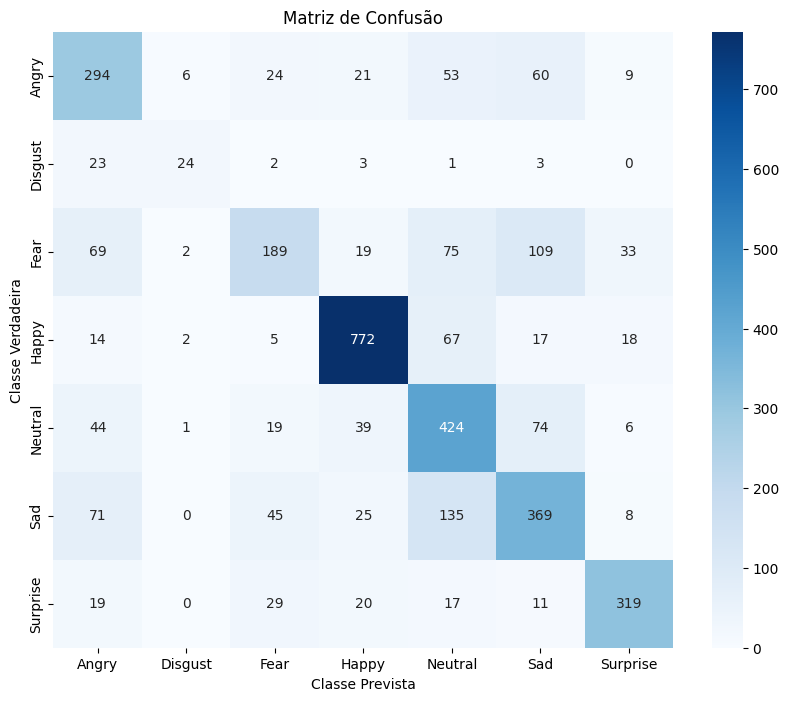

In [8]:
dataset_path = '../data/Fer-2013/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

    # Preparar DataLoaders
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

    # Carregar o modelo
modelo = CustomResNet152(num_classes).get_model().to(device)
nameModel = 'novosModels/fer_dados1.pt'
patience = 5
    # Treinar e validar
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
historico = trainer.treinar_e_validar(epocas=30)


In [9]:
from sklearn.model_selection import ParameterGrid
import json
from tqdm import tqdm

class GridSearchTrainer:
    def __init__(self, model_class, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, param_grid, checkpoint_dir='checkpoints'):
        self.model_class = model_class
        self.data_loader_treino = data_loader_treino
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_treino = num_imagens_treino
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.num_classes = num_classes
        self.param_grid = param_grid
        self.checkpoint_dir = checkpoint_dir
        self.best_params = None
        self.best_accuracy = 0.0

        # Create directory for checkpoints
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train_and_evaluate(self, hyperparams):
        model = self.model_class(self.num_classes).get_model().to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])
        criterion = nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        best_accuracy = 0.0
        patience = hyperparams.get('patience', 5)
        early_stop_counter = 0

        for epoch in range(hyperparams['epochs']):
            print(f"\nEpoch {epoch + 1}/{hyperparams['epochs']}")
            model.train()
            train_loss, train_accuracy = self.run_epoch(model, criterion, optimizer, self.data_loader_treino, phase='train', epoch_progress=True)
            model.eval()
            val_loss, val_accuracy = self.run_epoch(model, criterion, optimizer, self.data_loader_validacao, phase='eval', epoch_progress=True)
            print(f"Train: Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%")
            scheduler.step(val_loss)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                early_stop_counter = 0
                # Save checkpoint with hyperparameters
                checkpoint_name = self.generate_checkpoint_name(hyperparams, epoch + 1, val_accuracy)
                torch.save({'model_state_dict': model.state_dict(),
                            'hyperparams': hyperparams,
                            'accuracy': val_accuracy}, os.path.join(self.checkpoint_dir, checkpoint_name))
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        return best_accuracy

    def run_epoch(self, model, criterion, optimizer, data_loader, phase, epoch_progress=False):
        total_loss = 0.0
        correct_predictions = 0

        with tqdm(total=len(data_loader), desc=f"{phase.capitalize()} Progress", leave=False) as pbar:
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                if phase == 'train':
                    optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels)

                if epoch_progress:
                    pbar.update(1)

        epoch_loss = total_loss / len(data_loader.dataset)
        epoch_accuracy = correct_predictions.double() / len(data_loader.dataset)

        return epoch_loss, epoch_accuracy.item()

    def perform_grid_search(self):
        grid = ParameterGrid(self.param_grid)
        for params in grid:
            print(f"Treinando com hiperparâmetros: {params}")
            accuracy = self.train_and_evaluate(params)

            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_params = params
                print(f"Novo melhor modelo encontrado com precisão: {accuracy:.4f}")

        print(f"Melhores hiperparâmetros: {self.best_params}")
        print(f"Melhor precisão de validação: {self.best_accuracy:.4f}")

    def generate_checkpoint_name(self, hyperparams, epoch, val_accuracy):
        # Generate a unique name for each checkpoint
        params_str = "_".join([f"{key}={value}" for key, value in hyperparams.items()])
        return f"checkpoint_{params_str}_epoch={epoch}_val_acc={val_accuracy:.4f}.pth"

# Configuração dos hiperparâmetros
param_grid = {
    'lr': [0.0001, 0.001],
    'weight_decay': [1e-4, 1e-5],
    'epochs': [20, 30],
    'patience': [3, 5]
}

# Treinamento com GridSearch
grid_search_trainer = GridSearchTrainer(CustomResNet50, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, param_grid)
grid_search_trainer.perform_grid_search()


Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.0001, 'patience': 3, 'weight_decay': 0.0001}


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/20


Train: Loss: 1.3638, Accuracy: 48.21%
Validation: Loss: 1.2064, Accuracy: 54.36%

Epoch 2/20


Train: Loss: 1.1840, Accuracy: 55.77%
Validation: Loss: 1.0853, Accuracy: 59.52%

Epoch 3/20


Train: Loss: 1.1239, Accuracy: 58.09%
Validation: Loss: 1.0969, Accuracy: 59.96%

Epoch 4/20


Train: Loss: 1.0774, Accuracy: 59.63%
Validation: Loss: 1.0426, Accuracy: 61.13%

Epoch 5/20


Train: Loss: 1.0433, Accuracy: 61.07%
Validation: Loss: 1.0126, Accuracy: 61.83%

Epoch 6/20


Train: Loss: 1.0189, Accuracy: 62.08%
Validation: Loss: 1.0207, Accuracy: 62.05%

Epoch 7/20


Train: Loss: 0.9984, Accuracy: 62.59%
Validation: Loss: 0.9821, Accuracy: 62.83%

Epoch 8/20


Train: Loss: 0.9653, Accuracy: 64.57%
Validation: Loss: 0.9864, Accuracy: 63.44%

Epoch 9/20


Train: Loss: 0.9631, Accuracy: 64.17%
Validation: Loss: 0.9794, Accuracy: 63.44%

Epoch 10/20


Train: Loss: 0.9388, Accuracy: 65.30%
Validation: Loss: 1.0271, Accuracy: 63.36%

Epoch 11/20


Train: Loss: 0.9251, Accuracy: 65.83%
Validation: Loss: 1.0085, Accuracy: 63.47%

Epoch 12/20


Train: Loss: 0.9099, Accuracy: 66.44%
Validation: Loss: 1.0284, Accuracy: 63.67%

Epoch 13/20


Train: Loss: 0.8967, Accuracy: 66.74%
Validation: Loss: 0.9845, Accuracy: 63.53%

Epoch 14/20


Train: Loss: 0.8240, Accuracy: 69.65%
Validation: Loss: 0.9772, Accuracy: 64.84%

Epoch 15/20


Train: Loss: 0.8068, Accuracy: 70.19%
Validation: Loss: 0.9684, Accuracy: 64.98%

Epoch 16/20


Train: Loss: 0.7916, Accuracy: 70.78%
Validation: Loss: 0.9692, Accuracy: 65.56%

Epoch 17/20


Train: Loss: 0.7782, Accuracy: 71.51%
Validation: Loss: 0.9794, Accuracy: 65.90%

Epoch 18/20


Train: Loss: 0.7757, Accuracy: 71.31%
Validation: Loss: 0.9814, Accuracy: 65.87%

Epoch 19/20


Train: Loss: 0.7652, Accuracy: 71.51%
Validation: Loss: 0.9876, Accuracy: 65.42%

Epoch 20/20


Train: Loss: 0.7524, Accuracy: 72.27%
Validation: Loss: 0.9893, Accuracy: 65.59%
Early stopping triggered.
Novo melhor modelo encontrado com precisão: 0.6590
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.0001, 'patience': 3, 'weight_decay': 1e-05}

Epoch 1/20


Train: Loss: 1.3611, Accuracy: 48.10%
Validation: Loss: 1.1565, Accuracy: 56.45%

Epoch 2/20


Train: Loss: 1.1796, Accuracy: 55.99%
Validation: Loss: 1.0823, Accuracy: 57.76%

Epoch 3/20


Train: Loss: 1.1162, Accuracy: 58.22%
Validation: Loss: 1.0461, Accuracy: 60.85%

Epoch 4/20


Train: Loss: 1.0768, Accuracy: 60.21%
Validation: Loss: 1.0437, Accuracy: 61.72%

Epoch 5/20


Train: Loss: 1.0416, Accuracy: 61.30%
Validation: Loss: 0.9926, Accuracy: 63.53%

Epoch 6/20


Train: Loss: 1.0125, Accuracy: 62.56%
Validation: Loss: 0.9952, Accuracy: 63.03%

Epoch 7/20


Train: Loss: 0.9934, Accuracy: 62.82%
Validation: Loss: 1.0821, Accuracy: 60.55%

Epoch 8/20


Train: Loss: 0.9658, Accuracy: 64.09%
Validation: Loss: 1.0047, Accuracy: 63.19%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.0001, 'patience': 5, 'weight_decay': 0.0001}

Epoch 1/20


Train: Loss: 1.3595, Accuracy: 48.04%
Validation: Loss: 1.4009, Accuracy: 50.40%

Epoch 2/20


Train: Loss: 1.1809, Accuracy: 55.79%
Validation: Loss: 1.1497, Accuracy: 56.17%

Epoch 3/20


Train: Loss: 1.1152, Accuracy: 58.53%
Validation: Loss: 1.0622, Accuracy: 58.96%

Epoch 4/20


Train: Loss: 1.0757, Accuracy: 59.67%
Validation: Loss: 1.0326, Accuracy: 61.97%

Epoch 5/20


Train: Loss: 1.0438, Accuracy: 61.17%
Validation: Loss: 1.0390, Accuracy: 61.60%

Epoch 6/20


Train: Loss: 1.0169, Accuracy: 62.26%
Validation: Loss: 0.9747, Accuracy: 63.17%

Epoch 7/20


Train: Loss: 0.9865, Accuracy: 63.72%
Validation: Loss: 1.0455, Accuracy: 62.30%

Epoch 8/20


Train: Loss: 0.9723, Accuracy: 63.81%
Validation: Loss: 0.9737, Accuracy: 63.39%

Epoch 9/20


Train: Loss: 0.9571, Accuracy: 64.32%
Validation: Loss: 1.0299, Accuracy: 63.39%

Epoch 10/20


Train: Loss: 0.9333, Accuracy: 65.38%
Validation: Loss: 0.9787, Accuracy: 64.86%

Epoch 11/20


Train: Loss: 0.9208, Accuracy: 65.93%
Validation: Loss: 1.0098, Accuracy: 63.30%

Epoch 12/20


Train: Loss: 0.9031, Accuracy: 66.75%
Validation: Loss: 0.9957, Accuracy: 64.56%

Epoch 13/20


Train: Loss: 0.8364, Accuracy: 68.88%
Validation: Loss: 0.9576, Accuracy: 65.42%

Epoch 14/20


Train: Loss: 0.8071, Accuracy: 69.99%
Validation: Loss: 0.9827, Accuracy: 65.56%

Epoch 15/20


Train: Loss: 0.7968, Accuracy: 70.64%
Validation: Loss: 0.9829, Accuracy: 65.34%

Epoch 16/20


Train: Loss: 0.7885, Accuracy: 71.03%
Validation: Loss: 0.9626, Accuracy: 65.84%

Epoch 17/20


Train: Loss: 0.7743, Accuracy: 71.56%
Validation: Loss: 0.9753, Accuracy: 65.70%

Epoch 18/20


Train: Loss: 0.7630, Accuracy: 71.90%
Validation: Loss: 0.9740, Accuracy: 66.01%

Epoch 19/20


Train: Loss: 0.7634, Accuracy: 71.90%
Validation: Loss: 0.9734, Accuracy: 65.56%

Epoch 20/20


Train: Loss: 0.7669, Accuracy: 71.56%
Validation: Loss: 0.9854, Accuracy: 65.90%
Novo melhor modelo encontrado com precisão: 0.6601
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.0001, 'patience': 5, 'weight_decay': 1e-05}

Epoch 1/20


Train: Loss: 1.3551, Accuracy: 48.30%
Validation: Loss: 1.1547, Accuracy: 55.67%

Epoch 2/20


Train: Loss: 1.1793, Accuracy: 56.14%
Validation: Loss: 1.0972, Accuracy: 59.15%

Epoch 3/20


Train: Loss: 1.1163, Accuracy: 58.77%
Validation: Loss: 1.0461, Accuracy: 60.80%

Epoch 4/20


Train: Loss: 1.0736, Accuracy: 60.17%
Validation: Loss: 1.0259, Accuracy: 62.27%

Epoch 5/20


Train: Loss: 1.0404, Accuracy: 61.70%
Validation: Loss: 1.0347, Accuracy: 61.30%

Epoch 6/20


Train: Loss: 1.0118, Accuracy: 62.56%
Validation: Loss: 1.0186, Accuracy: 61.88%

Epoch 7/20


Train: Loss: 0.9829, Accuracy: 63.39%
Validation: Loss: 1.0797, Accuracy: 61.97%

Epoch 8/20


Train: Loss: 0.9691, Accuracy: 64.12%
Validation: Loss: 1.0083, Accuracy: 62.36%

Epoch 9/20


Train: Loss: 0.9476, Accuracy: 64.63%
Validation: Loss: 1.0282, Accuracy: 63.69%

Epoch 10/20


Train: Loss: 0.9278, Accuracy: 65.85%
Validation: Loss: 1.0199, Accuracy: 62.75%

Epoch 11/20


Train: Loss: 0.9046, Accuracy: 66.23%
Validation: Loss: 1.0053, Accuracy: 64.53%

Epoch 12/20


Train: Loss: 0.9017, Accuracy: 66.79%
Validation: Loss: 0.9733, Accuracy: 65.62%

Epoch 13/20


Train: Loss: 0.8819, Accuracy: 67.54%
Validation: Loss: 1.0171, Accuracy: 63.08%

Epoch 14/20


Train: Loss: 0.8656, Accuracy: 68.09%
Validation: Loss: 1.0037, Accuracy: 65.09%

Epoch 15/20


Train: Loss: 0.8492, Accuracy: 69.16%
Validation: Loss: 1.0018, Accuracy: 64.45%

Epoch 16/20


Train: Loss: 0.8368, Accuracy: 69.45%
Validation: Loss: 0.9758, Accuracy: 64.50%

Epoch 17/20


Train: Loss: 0.7646, Accuracy: 71.94%
Validation: Loss: 0.9811, Accuracy: 66.17%

Epoch 18/20


Train: Loss: 0.7432, Accuracy: 72.59%
Validation: Loss: 0.9753, Accuracy: 66.37%

Epoch 19/20


Train: Loss: 0.7259, Accuracy: 73.28%
Validation: Loss: 1.0039, Accuracy: 66.20%

Epoch 20/20


Train: Loss: 0.7204, Accuracy: 73.40%
Validation: Loss: 1.0085, Accuracy: 66.20%
Novo melhor modelo encontrado com precisão: 0.6637
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.001, 'patience': 3, 'weight_decay': 0.0001}

Epoch 1/20


Train: Loss: 1.4591, Accuracy: 44.11%
Validation: Loss: 1.3794, Accuracy: 47.70%

Epoch 2/20


Train: Loss: 1.2984, Accuracy: 50.71%
Validation: Loss: 1.2839, Accuracy: 51.18%

Epoch 3/20


Train: Loss: 1.2308, Accuracy: 53.88%
Validation: Loss: 1.1539, Accuracy: 56.09%

Epoch 4/20


Train: Loss: 1.1900, Accuracy: 55.77%
Validation: Loss: 1.1506, Accuracy: 56.62%

Epoch 5/20


Train: Loss: 1.1635, Accuracy: 56.88%
Validation: Loss: 1.0932, Accuracy: 58.34%

Epoch 6/20


Train: Loss: 1.1407, Accuracy: 57.72%
Validation: Loss: 1.0819, Accuracy: 58.87%

Epoch 7/20


Train: Loss: 1.1155, Accuracy: 58.20%
Validation: Loss: 1.0617, Accuracy: 60.10%

Epoch 8/20


Train: Loss: 1.0950, Accuracy: 59.47%
Validation: Loss: 1.1249, Accuracy: 58.43%

Epoch 9/20


Train: Loss: 1.0803, Accuracy: 60.03%
Validation: Loss: 1.1042, Accuracy: 58.79%

Epoch 10/20


Train: Loss: 1.0728, Accuracy: 60.18%
Validation: Loss: 1.0472, Accuracy: 61.08%

Epoch 11/20


Train: Loss: 1.0581, Accuracy: 60.59%
Validation: Loss: 1.0680, Accuracy: 60.27%

Epoch 12/20


Train: Loss: 1.0455, Accuracy: 61.27%
Validation: Loss: 1.0939, Accuracy: 59.54%

Epoch 13/20


Train: Loss: 1.0393, Accuracy: 61.45%
Validation: Loss: 1.0518, Accuracy: 60.55%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.001, 'patience': 3, 'weight_decay': 1e-05}

Epoch 1/20


Train: Loss: 1.4466, Accuracy: 44.48%
Validation: Loss: 1.2407, Accuracy: 52.55%

Epoch 2/20


Train: Loss: 1.2790, Accuracy: 51.81%
Validation: Loss: 1.1703, Accuracy: 55.64%

Epoch 3/20


Train: Loss: 1.2199, Accuracy: 54.76%
Validation: Loss: 1.1186, Accuracy: 57.62%

Epoch 4/20


Train: Loss: 1.1814, Accuracy: 56.26%
Validation: Loss: 1.0916, Accuracy: 59.35%

Epoch 5/20


Train: Loss: 1.1449, Accuracy: 57.79%
Validation: Loss: 1.0817, Accuracy: 59.54%

Epoch 6/20


Train: Loss: 1.1179, Accuracy: 58.76%
Validation: Loss: 1.0926, Accuracy: 59.24%

Epoch 7/20


Train: Loss: 1.0901, Accuracy: 60.17%
Validation: Loss: 1.0895, Accuracy: 59.77%

Epoch 8/20


Train: Loss: 1.0729, Accuracy: 60.39%
Validation: Loss: 1.0926, Accuracy: 58.60%

Epoch 9/20


Train: Loss: 1.0589, Accuracy: 61.05%
Validation: Loss: 1.0478, Accuracy: 61.74%

Epoch 10/20


Train: Loss: 1.0364, Accuracy: 61.71%
Validation: Loss: 1.0160, Accuracy: 61.72%

Epoch 11/20


Train: Loss: 1.0244, Accuracy: 62.17%
Validation: Loss: 1.0259, Accuracy: 61.30%

Epoch 12/20


Train: Loss: 1.0096, Accuracy: 62.68%
Validation: Loss: 1.0153, Accuracy: 61.86%

Epoch 13/20


Train: Loss: 0.9961, Accuracy: 62.97%
Validation: Loss: 1.0138, Accuracy: 61.63%

Epoch 14/20


Train: Loss: 0.9752, Accuracy: 63.92%
Validation: Loss: 1.0153, Accuracy: 62.19%

Epoch 15/20


Train: Loss: 0.9674, Accuracy: 64.33%
Validation: Loss: 0.9978, Accuracy: 62.72%

Epoch 16/20


Train: Loss: 0.9587, Accuracy: 64.25%
Validation: Loss: 1.0080, Accuracy: 62.30%

Epoch 17/20


Train: Loss: 0.9444, Accuracy: 64.96%
Validation: Loss: 1.0169, Accuracy: 62.83%

Epoch 18/20


Train: Loss: 0.9393, Accuracy: 65.43%
Validation: Loss: 1.0302, Accuracy: 61.91%

Epoch 19/20


Train: Loss: 0.9338, Accuracy: 65.37%
Validation: Loss: 1.0235, Accuracy: 63.64%

Epoch 20/20


Train: Loss: 0.8690, Accuracy: 67.83%
Validation: Loss: 0.9895, Accuracy: 64.81%
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.001, 'patience': 5, 'weight_decay': 0.0001}

Epoch 1/20


Train: Loss: 1.4719, Accuracy: 43.34%
Validation: Loss: 1.2809, Accuracy: 50.79%

Epoch 2/20


Train: Loss: 1.3199, Accuracy: 49.94%
Validation: Loss: 1.1926, Accuracy: 54.53%

Epoch 3/20


Train: Loss: 1.2585, Accuracy: 52.79%
Validation: Loss: 1.1574, Accuracy: 56.70%

Epoch 4/20


Train: Loss: 1.2170, Accuracy: 54.76%
Validation: Loss: 1.1437, Accuracy: 57.54%

Epoch 5/20


Train: Loss: 1.1760, Accuracy: 56.35%
Validation: Loss: 1.0997, Accuracy: 59.60%

Epoch 6/20


Train: Loss: 1.1516, Accuracy: 56.79%
Validation: Loss: 1.1251, Accuracy: 57.87%

Epoch 7/20


Train: Loss: 1.1216, Accuracy: 58.13%
Validation: Loss: 1.0513, Accuracy: 61.55%

Epoch 8/20


Train: Loss: 1.1082, Accuracy: 59.23%
Validation: Loss: 1.0312, Accuracy: 61.58%

Epoch 9/20


Train: Loss: 1.1022, Accuracy: 59.23%
Validation: Loss: 1.0892, Accuracy: 59.18%

Epoch 10/20


Train: Loss: 1.0780, Accuracy: 60.10%
Validation: Loss: 1.0438, Accuracy: 60.32%

Epoch 11/20


Train: Loss: 1.0698, Accuracy: 60.60%
Validation: Loss: 1.0685, Accuracy: 60.32%

Epoch 12/20


Train: Loss: 1.0592, Accuracy: 60.71%
Validation: Loss: 1.0674, Accuracy: 59.79%

Epoch 13/20


Train: Loss: 0.9941, Accuracy: 62.87%
Validation: Loss: 0.9948, Accuracy: 62.78%

Epoch 14/20


Train: Loss: 0.9747, Accuracy: 63.73%
Validation: Loss: 0.9979, Accuracy: 62.33%

Epoch 15/20


Train: Loss: 0.9675, Accuracy: 63.94%
Validation: Loss: 0.9809, Accuracy: 63.14%

Epoch 16/20


Train: Loss: 0.9539, Accuracy: 64.75%
Validation: Loss: 0.9831, Accuracy: 63.47%

Epoch 17/20


Train: Loss: 0.9501, Accuracy: 64.68%
Validation: Loss: 0.9776, Accuracy: 63.30%

Epoch 18/20


Train: Loss: 0.9410, Accuracy: 65.04%
Validation: Loss: 0.9702, Accuracy: 63.83%

Epoch 19/20


Train: Loss: 0.9351, Accuracy: 65.18%
Validation: Loss: 0.9784, Accuracy: 63.19%

Epoch 20/20


Train: Loss: 0.9353, Accuracy: 65.23%
Validation: Loss: 0.9713, Accuracy: 63.64%
Treinando com hiperparâmetros: {'epochs': 20, 'lr': 0.001, 'patience': 5, 'weight_decay': 1e-05}

Epoch 1/20


Train: Loss: 1.4452, Accuracy: 44.29%
Validation: Loss: 1.2858, Accuracy: 50.88%

Epoch 2/20


Train: Loss: 1.2831, Accuracy: 51.39%
Validation: Loss: 1.2502, Accuracy: 53.30%

Epoch 3/20


Train: Loss: 1.2249, Accuracy: 54.27%
Validation: Loss: 1.1584, Accuracy: 56.12%

Epoch 4/20


Train: Loss: 1.1743, Accuracy: 56.30%
Validation: Loss: 1.0856, Accuracy: 59.26%

Epoch 5/20


Train: Loss: 1.1413, Accuracy: 57.17%
Validation: Loss: 1.1174, Accuracy: 58.46%

Epoch 6/20


Train: Loss: 1.1120, Accuracy: 59.14%
Validation: Loss: 1.0554, Accuracy: 60.57%

Epoch 7/20


Train: Loss: 1.0850, Accuracy: 59.93%
Validation: Loss: 1.0442, Accuracy: 60.82%

Epoch 8/20


Train: Loss: 1.0720, Accuracy: 60.68%
Validation: Loss: 1.0472, Accuracy: 61.02%

Epoch 9/20


Train: Loss: 1.0463, Accuracy: 61.34%
Validation: Loss: 1.0495, Accuracy: 60.46%

Epoch 10/20


Train: Loss: 1.0316, Accuracy: 61.79%
Validation: Loss: 1.0223, Accuracy: 61.91%

Epoch 11/20


Train: Loss: 1.0198, Accuracy: 62.31%
Validation: Loss: 1.0240, Accuracy: 62.64%

Epoch 12/20


Train: Loss: 1.0053, Accuracy: 62.92%
Validation: Loss: 1.0703, Accuracy: 61.30%

Epoch 13/20


Train: Loss: 0.9919, Accuracy: 63.13%
Validation: Loss: 1.0097, Accuracy: 62.61%

Epoch 14/20


Train: Loss: 0.9770, Accuracy: 63.78%
Validation: Loss: 1.0368, Accuracy: 62.75%

Epoch 15/20


Train: Loss: 0.9660, Accuracy: 64.02%
Validation: Loss: 1.0015, Accuracy: 63.47%

Epoch 16/20


Train: Loss: 0.9515, Accuracy: 64.79%
Validation: Loss: 1.0232, Accuracy: 62.72%

Epoch 17/20


Train: Loss: 0.9487, Accuracy: 64.78%
Validation: Loss: 1.0474, Accuracy: 62.22%

Epoch 18/20


Train: Loss: 0.9367, Accuracy: 65.38%
Validation: Loss: 1.0049, Accuracy: 63.69%

Epoch 19/20


Train: Loss: 0.9287, Accuracy: 65.90%
Validation: Loss: 1.1051, Accuracy: 61.41%

Epoch 20/20


Train: Loss: 0.8679, Accuracy: 67.56%
Validation: Loss: 0.9833, Accuracy: 65.20%
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.0001, 'patience': 3, 'weight_decay': 0.0001}

Epoch 1/30


Train: Loss: 1.3659, Accuracy: 47.63%
Validation: Loss: 1.1319, Accuracy: 57.26%

Epoch 2/30


Train: Loss: 1.1846, Accuracy: 55.67%
Validation: Loss: 1.0727, Accuracy: 59.96%

Epoch 3/30


Train: Loss: 1.1247, Accuracy: 57.83%
Validation: Loss: 1.0465, Accuracy: 61.19%

Epoch 4/30


Train: Loss: 1.0755, Accuracy: 59.70%
Validation: Loss: 1.0764, Accuracy: 61.16%

Epoch 5/30


Train: Loss: 1.0489, Accuracy: 61.11%
Validation: Loss: 1.0340, Accuracy: 62.19%

Epoch 6/30


Train: Loss: 1.0222, Accuracy: 62.02%
Validation: Loss: 0.9979, Accuracy: 63.47%

Epoch 7/30


Train: Loss: 0.9928, Accuracy: 63.12%
Validation: Loss: 1.0135, Accuracy: 61.99%

Epoch 8/30


Train: Loss: 0.9809, Accuracy: 63.81%
Validation: Loss: 1.0010, Accuracy: 63.17%

Epoch 9/30


Train: Loss: 0.9587, Accuracy: 64.43%
Validation: Loss: 0.9963, Accuracy: 63.58%

Epoch 10/30


Train: Loss: 0.9419, Accuracy: 65.22%
Validation: Loss: 1.0125, Accuracy: 64.08%

Epoch 11/30


Train: Loss: 0.9280, Accuracy: 65.46%
Validation: Loss: 1.0302, Accuracy: 62.91%

Epoch 12/30


Train: Loss: 0.9120, Accuracy: 65.94%
Validation: Loss: 1.0014, Accuracy: 63.83%

Epoch 13/30


Train: Loss: 0.8982, Accuracy: 66.71%
Validation: Loss: 0.9515, Accuracy: 65.51%

Epoch 14/30


Train: Loss: 0.8811, Accuracy: 67.42%
Validation: Loss: 0.9725, Accuracy: 64.56%

Epoch 15/30


Train: Loss: 0.8699, Accuracy: 68.09%
Validation: Loss: 0.9666, Accuracy: 65.14%

Epoch 16/30


Train: Loss: 0.8539, Accuracy: 68.25%
Validation: Loss: 0.9802, Accuracy: 64.92%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.0001, 'patience': 3, 'weight_decay': 1e-05}

Epoch 1/30


Train: Loss: 1.3603, Accuracy: 47.93%
Validation: Loss: 1.1471, Accuracy: 56.81%

Epoch 2/30


Train: Loss: 1.1799, Accuracy: 56.14%
Validation: Loss: 1.1345, Accuracy: 57.76%

Epoch 3/30


Train: Loss: 1.1246, Accuracy: 58.17%
Validation: Loss: 1.0411, Accuracy: 60.38%

Epoch 4/30


Train: Loss: 1.0790, Accuracy: 59.75%
Validation: Loss: 1.0394, Accuracy: 60.71%

Epoch 5/30


Train: Loss: 1.0379, Accuracy: 61.51%
Validation: Loss: 0.9959, Accuracy: 62.64%

Epoch 6/30


Train: Loss: 1.0142, Accuracy: 62.51%
Validation: Loss: 1.0128, Accuracy: 62.58%

Epoch 7/30


Train: Loss: 0.9873, Accuracy: 63.51%
Validation: Loss: 1.0096, Accuracy: 62.97%

Epoch 8/30


Train: Loss: 0.9691, Accuracy: 64.44%
Validation: Loss: 1.0040, Accuracy: 63.39%

Epoch 9/30


Train: Loss: 0.9479, Accuracy: 65.05%
Validation: Loss: 0.9714, Accuracy: 63.86%

Epoch 10/30


Train: Loss: 0.9323, Accuracy: 65.73%
Validation: Loss: 0.9606, Accuracy: 64.84%

Epoch 11/30


Train: Loss: 0.9115, Accuracy: 66.12%
Validation: Loss: 0.9708, Accuracy: 64.06%

Epoch 12/30


Train: Loss: 0.8915, Accuracy: 67.02%
Validation: Loss: 0.9811, Accuracy: 65.00%

Epoch 13/30


Train: Loss: 0.8803, Accuracy: 67.38%
Validation: Loss: 0.9558, Accuracy: 66.06%

Epoch 14/30


Train: Loss: 0.8618, Accuracy: 68.18%
Validation: Loss: 0.9807, Accuracy: 65.23%

Epoch 15/30


Train: Loss: 0.8508, Accuracy: 68.56%
Validation: Loss: 0.9580, Accuracy: 65.90%

Epoch 16/30


Train: Loss: 0.8431, Accuracy: 69.15%
Validation: Loss: 0.9593, Accuracy: 65.45%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.0001, 'patience': 5, 'weight_decay': 0.0001}

Epoch 1/30


Train: Loss: 1.3608, Accuracy: 48.60%
Validation: Loss: 1.1550, Accuracy: 55.53%

Epoch 2/30


Train: Loss: 1.1809, Accuracy: 55.84%
Validation: Loss: 1.0868, Accuracy: 59.04%

Epoch 3/30


Train: Loss: 1.1196, Accuracy: 58.07%
Validation: Loss: 1.0611, Accuracy: 60.88%

Epoch 4/30


Train: Loss: 1.0814, Accuracy: 59.90%
Validation: Loss: 1.0219, Accuracy: 62.25%

Epoch 5/30


Train: Loss: 1.0409, Accuracy: 61.43%
Validation: Loss: 1.0354, Accuracy: 62.16%

Epoch 6/30


Train: Loss: 1.0157, Accuracy: 62.51%
Validation: Loss: 1.0002, Accuracy: 62.64%

Epoch 7/30


Train: Loss: 0.9881, Accuracy: 63.26%
Validation: Loss: 1.0087, Accuracy: 63.08%

Epoch 8/30


Train: Loss: 0.9758, Accuracy: 63.60%
Validation: Loss: 0.9956, Accuracy: 63.30%

Epoch 9/30


Train: Loss: 0.9608, Accuracy: 64.36%
Validation: Loss: 1.0354, Accuracy: 63.36%

Epoch 10/30


Train: Loss: 0.9423, Accuracy: 65.09%
Validation: Loss: 1.0105, Accuracy: 63.75%

Epoch 11/30


Train: Loss: 0.9212, Accuracy: 65.93%
Validation: Loss: 1.0056, Accuracy: 63.56%

Epoch 12/30


Train: Loss: 0.9072, Accuracy: 66.57%
Validation: Loss: 1.0107, Accuracy: 64.08%

Epoch 13/30


Train: Loss: 0.8347, Accuracy: 69.07%
Validation: Loss: 0.9831, Accuracy: 65.45%

Epoch 14/30


Train: Loss: 0.8100, Accuracy: 69.90%
Validation: Loss: 0.9762, Accuracy: 65.70%

Epoch 15/30


Train: Loss: 0.7967, Accuracy: 70.61%
Validation: Loss: 0.9789, Accuracy: 66.01%

Epoch 16/30


Train: Loss: 0.7919, Accuracy: 70.75%
Validation: Loss: 0.9917, Accuracy: 66.12%

Epoch 17/30


Train: Loss: 0.7832, Accuracy: 71.03%
Validation: Loss: 0.9860, Accuracy: 65.81%

Epoch 18/30


Train: Loss: 0.7835, Accuracy: 71.16%
Validation: Loss: 0.9909, Accuracy: 65.98%

Epoch 19/30


Train: Loss: 0.7671, Accuracy: 71.51%
Validation: Loss: 0.9698, Accuracy: 65.81%

Epoch 20/30


Train: Loss: 0.7641, Accuracy: 71.80%
Validation: Loss: 0.9811, Accuracy: 66.09%

Epoch 21/30


Train: Loss: 0.7581, Accuracy: 71.96%
Validation: Loss: 0.9784, Accuracy: 65.67%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.0001, 'patience': 5, 'weight_decay': 1e-05}

Epoch 1/30


Train: Loss: 1.3644, Accuracy: 47.86%
Validation: Loss: 1.1372, Accuracy: 57.01%

Epoch 2/30


Train: Loss: 1.1844, Accuracy: 56.03%
Validation: Loss: 1.0765, Accuracy: 59.85%

Epoch 3/30


Train: Loss: 1.1173, Accuracy: 58.50%
Validation: Loss: 1.0661, Accuracy: 59.35%

Epoch 4/30


Train: Loss: 1.0746, Accuracy: 59.89%
Validation: Loss: 1.0204, Accuracy: 61.63%

Epoch 5/30


Train: Loss: 1.0417, Accuracy: 61.09%
Validation: Loss: 1.0248, Accuracy: 62.02%

Epoch 6/30


Train: Loss: 1.0135, Accuracy: 62.40%
Validation: Loss: 1.0158, Accuracy: 63.14%

Epoch 7/30


Train: Loss: 0.9863, Accuracy: 63.66%
Validation: Loss: 1.0229, Accuracy: 62.69%

Epoch 8/30


Train: Loss: 0.9656, Accuracy: 64.16%
Validation: Loss: 1.0136, Accuracy: 62.91%

Epoch 9/30


Train: Loss: 0.9438, Accuracy: 64.61%
Validation: Loss: 1.0166, Accuracy: 63.61%

Epoch 10/30


Train: Loss: 0.9304, Accuracy: 65.31%
Validation: Loss: 1.0352, Accuracy: 62.50%

Epoch 11/30


Train: Loss: 0.9114, Accuracy: 66.07%
Validation: Loss: 0.9941, Accuracy: 64.34%

Epoch 12/30


Train: Loss: 0.8943, Accuracy: 66.99%
Validation: Loss: 0.9718, Accuracy: 65.23%

Epoch 13/30


Train: Loss: 0.8751, Accuracy: 67.74%
Validation: Loss: 0.9931, Accuracy: 65.28%

Epoch 14/30


Train: Loss: 0.8655, Accuracy: 68.08%
Validation: Loss: 1.0418, Accuracy: 63.17%

Epoch 15/30


Train: Loss: 0.8491, Accuracy: 68.45%
Validation: Loss: 0.9977, Accuracy: 65.70%

Epoch 16/30


Train: Loss: 0.8323, Accuracy: 69.17%
Validation: Loss: 0.9884, Accuracy: 65.14%

Epoch 17/30


Train: Loss: 0.7696, Accuracy: 71.75%
Validation: Loss: 1.0133, Accuracy: 65.23%

Epoch 18/30


Train: Loss: 0.7359, Accuracy: 72.93%
Validation: Loss: 0.9998, Accuracy: 66.17%

Epoch 19/30


Train: Loss: 0.7282, Accuracy: 73.26%
Validation: Loss: 1.0128, Accuracy: 66.04%

Epoch 20/30


Train: Loss: 0.7232, Accuracy: 73.42%
Validation: Loss: 1.0180, Accuracy: 65.70%

Epoch 21/30


Train: Loss: 0.7089, Accuracy: 73.96%
Validation: Loss: 1.0161, Accuracy: 66.62%

Epoch 22/30


Train: Loss: 0.7074, Accuracy: 73.98%
Validation: Loss: 1.0142, Accuracy: 65.98%

Epoch 23/30


Train: Loss: 0.6960, Accuracy: 74.58%
Validation: Loss: 1.0217, Accuracy: 66.20%

Epoch 24/30


Train: Loss: 0.7073, Accuracy: 74.21%
Validation: Loss: 1.0241, Accuracy: 65.98%

Epoch 25/30


Train: Loss: 0.7032, Accuracy: 74.21%
Validation: Loss: 1.0049, Accuracy: 65.78%

Epoch 26/30


Train: Loss: 0.7069, Accuracy: 74.00%
Validation: Loss: 1.0211, Accuracy: 66.12%
Early stopping triggered.
Novo melhor modelo encontrado com precisão: 0.6662
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.001, 'patience': 3, 'weight_decay': 0.0001}

Epoch 1/30


Train: Loss: 1.4602, Accuracy: 44.38%
Validation: Loss: 1.2707, Accuracy: 52.80%

Epoch 2/30


Train: Loss: 1.3081, Accuracy: 50.39%
Validation: Loss: 1.2244, Accuracy: 53.55%

Epoch 3/30


Train: Loss: 1.2513, Accuracy: 52.80%
Validation: Loss: 1.2274, Accuracy: 53.58%

Epoch 4/30


Train: Loss: 1.2065, Accuracy: 55.05%
Validation: Loss: 1.1308, Accuracy: 56.90%

Epoch 5/30


Train: Loss: 1.1759, Accuracy: 56.18%
Validation: Loss: 1.1363, Accuracy: 57.31%

Epoch 6/30


Train: Loss: 1.1468, Accuracy: 57.52%
Validation: Loss: 1.0921, Accuracy: 58.29%

Epoch 7/30


Train: Loss: 1.1261, Accuracy: 58.38%
Validation: Loss: 1.0845, Accuracy: 59.24%

Epoch 8/30


Train: Loss: 1.1045, Accuracy: 59.25%
Validation: Loss: 1.0641, Accuracy: 59.32%

Epoch 9/30


Train: Loss: 1.0914, Accuracy: 59.50%
Validation: Loss: 1.0816, Accuracy: 59.24%

Epoch 10/30


Train: Loss: 1.0783, Accuracy: 59.90%
Validation: Loss: 1.0331, Accuracy: 61.77%

Epoch 11/30


Train: Loss: 1.0650, Accuracy: 60.50%
Validation: Loss: 1.0353, Accuracy: 61.05%

Epoch 12/30


Train: Loss: 1.0529, Accuracy: 61.03%
Validation: Loss: 1.0350, Accuracy: 61.86%

Epoch 13/30


Train: Loss: 1.0439, Accuracy: 61.33%
Validation: Loss: 1.0611, Accuracy: 61.05%

Epoch 14/30


Train: Loss: 1.0306, Accuracy: 61.75%
Validation: Loss: 1.0003, Accuracy: 62.44%

Epoch 15/30


Train: Loss: 1.0207, Accuracy: 62.28%
Validation: Loss: 1.0102, Accuracy: 62.39%

Epoch 16/30


Train: Loss: 1.0159, Accuracy: 62.37%
Validation: Loss: 1.0165, Accuracy: 61.49%

Epoch 17/30


Train: Loss: 1.0101, Accuracy: 62.06%
Validation: Loss: 1.0304, Accuracy: 61.91%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.001, 'patience': 3, 'weight_decay': 1e-05}

Epoch 1/30


Train: Loss: 1.4555, Accuracy: 43.88%
Validation: Loss: 1.2602, Accuracy: 51.85%

Epoch 2/30


Train: Loss: 1.2936, Accuracy: 51.24%
Validation: Loss: 1.1963, Accuracy: 54.95%

Epoch 3/30


Train: Loss: 1.2253, Accuracy: 54.32%
Validation: Loss: 1.1177, Accuracy: 57.62%

Epoch 4/30


Train: Loss: 1.1748, Accuracy: 56.31%
Validation: Loss: 1.0728, Accuracy: 59.74%

Epoch 5/30


Train: Loss: 1.1456, Accuracy: 57.60%
Validation: Loss: 1.0854, Accuracy: 57.93%

Epoch 6/30


Train: Loss: 1.1165, Accuracy: 58.74%
Validation: Loss: 1.0839, Accuracy: 58.99%

Epoch 7/30


Train: Loss: 1.0931, Accuracy: 59.40%
Validation: Loss: 1.0604, Accuracy: 59.49%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.001, 'patience': 5, 'weight_decay': 0.0001}

Epoch 1/30


Train: Loss: 1.4403, Accuracy: 44.82%
Validation: Loss: 1.2524, Accuracy: 52.58%

Epoch 2/30


Train: Loss: 1.2996, Accuracy: 50.75%
Validation: Loss: 1.1810, Accuracy: 55.34%

Epoch 3/30


Train: Loss: 1.2365, Accuracy: 53.44%
Validation: Loss: 1.1672, Accuracy: 55.50%

Epoch 4/30


Train: Loss: 1.1951, Accuracy: 55.42%
Validation: Loss: 1.1030, Accuracy: 58.09%

Epoch 5/30


Train: Loss: 1.1644, Accuracy: 56.60%
Validation: Loss: 1.1137, Accuracy: 58.60%

Epoch 6/30


Train: Loss: 1.1359, Accuracy: 57.78%
Validation: Loss: 1.0619, Accuracy: 60.10%

Epoch 7/30


Train: Loss: 1.1107, Accuracy: 58.90%
Validation: Loss: 1.1722, Accuracy: 56.34%

Epoch 8/30


Train: Loss: 1.1018, Accuracy: 59.19%
Validation: Loss: 1.0941, Accuracy: 58.93%

Epoch 9/30


Train: Loss: 1.0865, Accuracy: 60.08%
Validation: Loss: 1.0382, Accuracy: 61.52%

Epoch 10/30


Train: Loss: 1.0685, Accuracy: 60.57%
Validation: Loss: 1.0673, Accuracy: 60.18%

Epoch 11/30


Train: Loss: 1.0600, Accuracy: 60.77%
Validation: Loss: 1.0583, Accuracy: 60.41%

Epoch 12/30


Train: Loss: 1.0432, Accuracy: 61.11%
Validation: Loss: 1.0428, Accuracy: 61.16%

Epoch 13/30


Train: Loss: 1.0323, Accuracy: 61.57%
Validation: Loss: 1.0833, Accuracy: 60.24%

Epoch 14/30


Train: Loss: 0.9796, Accuracy: 63.48%
Validation: Loss: 0.9966, Accuracy: 63.00%

Epoch 15/30


Train: Loss: 0.9543, Accuracy: 64.76%
Validation: Loss: 0.9856, Accuracy: 63.14%

Epoch 16/30


Train: Loss: 0.9496, Accuracy: 64.99%
Validation: Loss: 0.9929, Accuracy: 63.22%

Epoch 17/30


Train: Loss: 0.9388, Accuracy: 65.16%
Validation: Loss: 0.9838, Accuracy: 63.89%

Epoch 18/30


Train: Loss: 0.9364, Accuracy: 65.43%
Validation: Loss: 0.9788, Accuracy: 64.42%

Epoch 19/30


Train: Loss: 0.9299, Accuracy: 65.46%
Validation: Loss: 0.9851, Accuracy: 64.28%

Epoch 20/30


Train: Loss: 0.9253, Accuracy: 65.44%
Validation: Loss: 0.9825, Accuracy: 64.17%

Epoch 21/30


Train: Loss: 0.9171, Accuracy: 66.12%
Validation: Loss: 0.9755, Accuracy: 64.28%

Epoch 22/30


Train: Loss: 0.9115, Accuracy: 66.40%
Validation: Loss: 0.9880, Accuracy: 63.69%

Epoch 23/30


Train: Loss: 0.9098, Accuracy: 66.33%
Validation: Loss: 0.9711, Accuracy: 64.25%
Early stopping triggered.
Treinando com hiperparâmetros: {'epochs': 30, 'lr': 0.001, 'patience': 5, 'weight_decay': 1e-05}

Epoch 1/30


Train: Loss: 1.4519, Accuracy: 43.98%
Validation: Loss: 1.2788, Accuracy: 50.99%

Epoch 2/30


Train: Loss: 1.2865, Accuracy: 51.23%
Validation: Loss: 1.1811, Accuracy: 54.69%

Epoch 3/30


Train: Loss: 1.2266, Accuracy: 54.05%
Validation: Loss: 1.1247, Accuracy: 58.23%

Epoch 4/30


Train: Loss: 1.1808, Accuracy: 56.15%
Validation: Loss: 1.1158, Accuracy: 58.71%

Epoch 5/30


Train: Loss: 1.1496, Accuracy: 57.39%
Validation: Loss: 1.0931, Accuracy: 58.48%

Epoch 6/30


Train: Loss: 1.1274, Accuracy: 58.73%
Validation: Loss: 1.0748, Accuracy: 59.15%

Epoch 7/30


Train: Loss: 1.0999, Accuracy: 59.14%
Validation: Loss: 1.0499, Accuracy: 60.21%

Epoch 8/30


Train: Loss: 1.0846, Accuracy: 60.18%
Validation: Loss: 1.0389, Accuracy: 60.71%

Epoch 9/30


Train: Loss: 1.0552, Accuracy: 61.09%
Validation: Loss: 1.0973, Accuracy: 59.35%

Epoch 10/30


Train: Loss: 1.0369, Accuracy: 61.78%
Validation: Loss: 1.0848, Accuracy: 59.54%

Epoch 11/30


Train: Loss: 1.0243, Accuracy: 62.07%
Validation: Loss: 0.9819, Accuracy: 62.78%

Epoch 12/30


Train: Loss: 1.0167, Accuracy: 62.40%
Validation: Loss: 1.0083, Accuracy: 62.08%

Epoch 13/30


Train: Loss: 0.9977, Accuracy: 62.93%
Validation: Loss: 1.0027, Accuracy: 63.33%

Epoch 14/30


Train: Loss: 0.9873, Accuracy: 63.35%
Validation: Loss: 1.0446, Accuracy: 61.99%

Epoch 15/30


Train: Loss: 0.9753, Accuracy: 63.66%
Validation: Loss: 1.0574, Accuracy: 61.97%

Epoch 16/30


Train: Loss: 0.9169, Accuracy: 66.04%
Validation: Loss: 0.9696, Accuracy: 64.25%

Epoch 17/30


Train: Loss: 0.8949, Accuracy: 66.68%
Validation: Loss: 0.9687, Accuracy: 64.14%

Epoch 18/30


Train: Loss: 0.8916, Accuracy: 67.09%
Validation: Loss: 0.9707, Accuracy: 64.31%

Epoch 19/30


Train: Loss: 0.8795, Accuracy: 67.48%
Validation: Loss: 0.9713, Accuracy: 64.36%

Epoch 20/30


Train: Loss: 0.8730, Accuracy: 67.82%
Validation: Loss: 0.9791, Accuracy: 64.61%

Epoch 21/30


Train: Loss: 0.8711, Accuracy: 67.78%
Validation: Loss: 0.9760, Accuracy: 64.67%

Epoch 22/30


Train: Loss: 0.8575, Accuracy: 68.20%
Validation: Loss: 0.9820, Accuracy: 64.56%

Epoch 23/30


Train: Loss: 0.8540, Accuracy: 68.45%
Validation: Loss: 0.9826, Accuracy: 64.67%

Epoch 24/30


Train: Loss: 0.8499, Accuracy: 68.58%
Validation: Loss: 0.9856, Accuracy: 64.22%

Epoch 25/30


Train: Loss: 0.8529, Accuracy: 68.38%
Validation: Loss: 0.9837, Accuracy: 64.59%

Epoch 26/30


Train: Loss: 0.8498, Accuracy: 68.64%
Validation: Loss: 0.9750, Accuracy: 64.70%

Epoch 27/30


Train: Loss: 0.8565, Accuracy: 68.38%
Validation: Loss: 0.9873, Accuracy: 64.36%

Epoch 28/30


Train: Loss: 0.8518, Accuracy: 68.48%
Validation: Loss: 0.9924, Accuracy: 64.28%

Epoch 29/30


Train: Loss: 0.8517, Accuracy: 68.72%
Validation: Loss: 0.9813, Accuracy: 64.84%

Epoch 30/30


Train: Loss: 0.8536, Accuracy: 68.46%
Validation: Loss: 0.9853, Accuracy: 64.61%
Melhores hiperparâmetros: {'epochs': 30, 'lr': 0.0001, 'patience': 5, 'weight_decay': 1e-05}
Melhor precisão de validação: 0.6662


In [10]:
from sklearn.model_selection import ParameterSampler
import json
import random
from tqdm import tqdm

class RandomSearchTrainer:
    def __init__(self, model_class, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, param_dist, n_iter, checkpoint_dir='checkpoints'):
        self.model_class = model_class
        self.data_loader_treino = data_loader_treino
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_treino = num_imagens_treino
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.num_classes = num_classes
        self.param_dist = param_dist
        self.n_iter = n_iter
        self.checkpoint_dir = checkpoint_dir
        self.best_params = None
        self.best_accuracy = 0.0

        # Create directory for checkpoints
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train_and_evaluate(self, hyperparams):
        model = self.model_class(self.num_classes).get_model().to(self.device)
        optimizer = self.get_optimizer(hyperparams, model)
        criterion = nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        best_accuracy = 0.0
        patience = hyperparams.get('patience', 5)
        early_stop_counter = 0

        for epoch in range(hyperparams['epochs']):
            print(f"\nEpoch {epoch + 1}/{hyperparams['epochs']}")
            model.train()
            train_loss, train_accuracy = self.run_epoch(model, criterion, optimizer, self.data_loader_treino, phase='train', epoch_progress=True)
            model.eval()
            val_loss, val_accuracy = self.run_epoch(model, criterion, optimizer, self.data_loader_validacao, phase='eval', epoch_progress=True)
            print(f"Train: Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {val_accuracy * 100:.2f}%")
            scheduler.step(val_loss)

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                early_stop_counter = 0
                # Save checkpoint with hyperparameters
                checkpoint_name = self.generate_checkpoint_name(hyperparams, epoch + 1, val_accuracy)
                torch.save({'model_state_dict': model.state_dict(),
                            'hyperparams': hyperparams,
                            'accuracy': val_accuracy}, os.path.join(self.checkpoint_dir, checkpoint_name))
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

        return best_accuracy

    def run_epoch(self, model, criterion, optimizer, data_loader, phase, epoch_progress=False):
        total_loss = 0.0
        correct_predictions = 0

        with tqdm(total=len(data_loader), desc=f"{phase.capitalize()} Progress", leave=False) as pbar:
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                if phase == 'train':
                    optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels)

                if epoch_progress:
                    pbar.update(1)

        epoch_loss = total_loss / len(data_loader.dataset)
        epoch_accuracy = correct_predictions.double() / len(data_loader.dataset)

        return epoch_loss, epoch_accuracy.item()

    def perform_random_search(self):
        sampled_params = list(ParameterSampler(self.param_dist, n_iter=self.n_iter, random_state=random.randint(1, 10000)))
        for params in sampled_params:
            print(f"Treinando com hiperparâmetros: {params}")
            accuracy = self.train_and_evaluate(params)

            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_params = params
                print(f"Novo melhor modelo encontrado com precisão: {accuracy:.4f}")

        print(f"Melhores hiperparâmetros: {self.best_params}")
        print(f"Melhor precisão de validação: {self.best_accuracy:.4f}")

    def generate_checkpoint_name(self, hyperparams, epoch, val_accuracy):
        # Generate a unique name for each checkpoint
        params_str = "_".join([f"{key}={value}" for key, value in hyperparams.items()])
        return f"checkpoint_{params_str}_epoch={epoch}_val_acc={val_accuracy:.4f}.pth"

    def get_optimizer(self, hyperparams, model):
        if hyperparams['optimizer'] == 'adam':
            return optim.Adam(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'])
        elif hyperparams['optimizer'] == 'sgd':
            return optim.SGD(model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'], momentum=hyperparams.get('momentum', 0.9))
        else:
            raise ValueError(f"Optimizer {hyperparams['optimizer']} not supported.")

param_dist = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'weight_decay': [1e-4, 1e-5, 0],
    'epochs': [20, 30, 50],
    'patience': [3, 5, 7],
    'batch_size': [16, 32, 64],
    'optimizer': ['adam', 'sgd'],
    'momentum': [0.9, 0.95],  # Only relevant if optimizer is 'sgd'
    'activation': ['relu', 'tanh', 'sigmoid']  # Different activation functions to test
}

n_iter = 20

# Treinamento com Random Search
random_search_trainer = RandomSearchTrainer(CustomResNet50, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, param_dist, n_iter)
random_search_trainer.perform_random_search()


Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 7, 'optimizer': 'sgd', 'momentum': 0.9, 'lr': 0.001, 'epochs': 50, 'batch_size': 32, 'activation': 'tanh'}

Epoch 1/50


Train: Loss: 1.5896, Accuracy: 37.08%
Validation: Loss: 1.3441, Accuracy: 47.95%

Epoch 2/50


Train: Loss: 1.3287, Accuracy: 49.33%
Validation: Loss: 1.2197, Accuracy: 53.47%

Epoch 3/50


Train: Loss: 1.2410, Accuracy: 52.85%
Validation: Loss: 1.1418, Accuracy: 56.56%

Epoch 4/50


Train: Loss: 1.1787, Accuracy: 55.70%
Validation: Loss: 1.1240, Accuracy: 57.09%

Epoch 5/50


Train: Loss: 1.1321, Accuracy: 57.52%
Validation: Loss: 1.0881, Accuracy: 58.09%

Epoch 6/50


Train: Loss: 1.1016, Accuracy: 58.79%
Validation: Loss: 1.0877, Accuracy: 58.48%

Epoch 7/50


Train: Loss: 1.0807, Accuracy: 59.74%
Validation: Loss: 1.0602, Accuracy: 59.88%

Epoch 8/50


Train: Loss: 1.0575, Accuracy: 60.30%
Validation: Loss: 1.0304, Accuracy: 60.69%

Epoch 9/50


Train: Loss: 1.0284, Accuracy: 61.40%
Validation: Loss: 1.0265, Accuracy: 61.02%

Epoch 10/50


Train: Loss: 1.0075, Accuracy: 62.09%
Validation: Loss: 1.0266, Accuracy: 62.08%

Epoch 11/50


Train: Loss: 1.0022, Accuracy: 62.45%
Validation: Loss: 1.0155, Accuracy: 62.97%

Epoch 12/50


Train: Loss: 0.9823, Accuracy: 63.30%
Validation: Loss: 1.0175, Accuracy: 62.02%

Epoch 13/50


Train: Loss: 0.9632, Accuracy: 63.94%
Validation: Loss: 1.0142, Accuracy: 62.52%

Epoch 14/50


Train: Loss: 0.9519, Accuracy: 64.55%
Validation: Loss: 0.9947, Accuracy: 63.14%

Epoch 15/50


Train: Loss: 0.9318, Accuracy: 65.44%
Validation: Loss: 0.9920, Accuracy: 63.81%

Epoch 16/50


Train: Loss: 0.9219, Accuracy: 65.43%
Validation: Loss: 0.9787, Accuracy: 63.56%

Epoch 17/50


Train: Loss: 0.9121, Accuracy: 65.84%
Validation: Loss: 0.9822, Accuracy: 63.83%

Epoch 18/50


Train: Loss: 0.8993, Accuracy: 66.53%
Validation: Loss: 0.9810, Accuracy: 64.20%

Epoch 19/50


Train: Loss: 0.8890, Accuracy: 67.03%
Validation: Loss: 1.0027, Accuracy: 63.67%

Epoch 20/50


Train: Loss: 0.8686, Accuracy: 67.61%
Validation: Loss: 0.9722, Accuracy: 64.92%

Epoch 21/50


Train: Loss: 0.8680, Accuracy: 67.51%
Validation: Loss: 0.9818, Accuracy: 65.09%

Epoch 22/50


Train: Loss: 0.8567, Accuracy: 68.08%
Validation: Loss: 0.9757, Accuracy: 64.84%

Epoch 23/50


Train: Loss: 0.8474, Accuracy: 68.61%
Validation: Loss: 1.0194, Accuracy: 63.39%

Epoch 24/50


Train: Loss: 0.8343, Accuracy: 68.87%
Validation: Loss: 1.0082, Accuracy: 63.81%

Epoch 25/50


Train: Loss: 0.7727, Accuracy: 71.61%
Validation: Loss: 0.9808, Accuracy: 65.51%

Epoch 26/50


Train: Loss: 0.7544, Accuracy: 71.97%
Validation: Loss: 0.9838, Accuracy: 65.87%

Epoch 27/50


Train: Loss: 0.7499, Accuracy: 72.13%
Validation: Loss: 0.9840, Accuracy: 65.67%

Epoch 28/50


Train: Loss: 0.7368, Accuracy: 72.80%
Validation: Loss: 0.9960, Accuracy: 65.90%

Epoch 29/50


Train: Loss: 0.7400, Accuracy: 72.58%
Validation: Loss: 0.9993, Accuracy: 65.56%

Epoch 30/50


Train: Loss: 0.7280, Accuracy: 72.93%
Validation: Loss: 0.9949, Accuracy: 65.37%

Epoch 31/50


Train: Loss: 0.7327, Accuracy: 72.81%
Validation: Loss: 0.9946, Accuracy: 65.42%

Epoch 32/50


Train: Loss: 0.7316, Accuracy: 72.68%
Validation: Loss: 0.9955, Accuracy: 65.51%

Epoch 33/50


Train: Loss: 0.7320, Accuracy: 72.81%
Validation: Loss: 0.9896, Accuracy: 65.25%

Epoch 34/50


Train: Loss: 0.7318, Accuracy: 73.00%
Validation: Loss: 1.0015, Accuracy: 65.45%

Epoch 35/50


Train: Loss: 0.7316, Accuracy: 72.76%
Validation: Loss: 0.9861, Accuracy: 65.76%
Early stopping triggered.
Novo melhor modelo encontrado com precisão: 0.6590
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.01, 'epochs': 20, 'batch_size': 32, 'activation': 'relu'}

Epoch 1/20


Train: Loss: 1.6678, Accuracy: 36.31%
Validation: Loss: 1.3485, Accuracy: 48.40%

Epoch 2/20


Train: Loss: 1.4177, Accuracy: 46.19%
Validation: Loss: 1.2802, Accuracy: 52.33%

Epoch 3/20


Train: Loss: 1.3405, Accuracy: 48.78%
Validation: Loss: 1.2649, Accuracy: 51.69%

Epoch 4/20


Train: Loss: 1.3069, Accuracy: 50.00%
Validation: Loss: 1.2347, Accuracy: 52.83%

Epoch 5/20


Train: Loss: 1.2689, Accuracy: 51.67%
Validation: Loss: 1.1866, Accuracy: 55.08%

Epoch 6/20


Train: Loss: 1.2533, Accuracy: 52.81%
Validation: Loss: 1.1808, Accuracy: 55.75%

Epoch 7/20


Train: Loss: 1.2370, Accuracy: 53.15%
Validation: Loss: 1.1906, Accuracy: 54.61%

Epoch 8/20


Train: Loss: 1.2130, Accuracy: 54.49%
Validation: Loss: 1.1256, Accuracy: 56.62%

Epoch 9/20


Train: Loss: 1.1976, Accuracy: 55.25%
Validation: Loss: 1.1491, Accuracy: 56.23%

Epoch 10/20


Train: Loss: 1.1825, Accuracy: 56.17%
Validation: Loss: 1.1168, Accuracy: 57.65%

Epoch 11/20


Train: Loss: 1.1700, Accuracy: 56.71%
Validation: Loss: 1.1143, Accuracy: 57.93%

Epoch 12/20


Train: Loss: 1.1630, Accuracy: 56.77%
Validation: Loss: 1.0875, Accuracy: 59.57%

Epoch 13/20


Train: Loss: 1.1571, Accuracy: 57.12%
Validation: Loss: 1.0813, Accuracy: 58.93%

Epoch 14/20


Train: Loss: 1.1523, Accuracy: 57.51%
Validation: Loss: 1.0826, Accuracy: 58.99%

Epoch 15/20


Train: Loss: 1.1370, Accuracy: 58.09%
Validation: Loss: 1.0561, Accuracy: 59.77%

Epoch 16/20


Train: Loss: 1.1332, Accuracy: 57.78%
Validation: Loss: 1.0646, Accuracy: 59.10%

Epoch 17/20


Train: Loss: 1.1284, Accuracy: 58.72%
Validation: Loss: 1.0616, Accuracy: 59.77%

Epoch 18/20


Train: Loss: 1.1256, Accuracy: 58.36%
Validation: Loss: 1.0647, Accuracy: 60.04%

Epoch 19/20


Train: Loss: 1.1121, Accuracy: 59.11%
Validation: Loss: 1.0651, Accuracy: 59.96%

Epoch 20/20


Train: Loss: 1.0729, Accuracy: 60.63%
Validation: Loss: 1.0378, Accuracy: 60.94%
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'sgd', 'momentum': 0.9, 'lr': 0.1, 'epochs': 50, 'batch_size': 64, 'activation': 'relu'}

Epoch 1/50


Train: Loss: 1.8240, Accuracy: 24.81%
Validation: Loss: 1.8163, Accuracy: 24.94%

Epoch 2/50


Train: Loss: 1.8162, Accuracy: 24.52%
Validation: Loss: 1.8192, Accuracy: 24.94%

Epoch 3/50


Train: Loss: 1.8159, Accuracy: 24.89%
Validation: Loss: 1.8149, Accuracy: 24.94%

Epoch 4/50


Train: Loss: 1.8165, Accuracy: 24.82%
Validation: Loss: 1.8153, Accuracy: 24.94%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 7, 'optimizer': 'adam', 'momentum': 0.9, 'lr': 0.0001, 'epochs': 30, 'batch_size': 16, 'activation': 'relu'}

Epoch 1/30


Train: Loss: 1.3539, Accuracy: 48.11%
Validation: Loss: 1.1294, Accuracy: 57.26%

Epoch 2/30


Train: Loss: 1.1800, Accuracy: 56.03%
Validation: Loss: 1.1059, Accuracy: 58.40%

Epoch 3/30


Train: Loss: 1.1222, Accuracy: 58.25%
Validation: Loss: 1.0394, Accuracy: 60.69%

Epoch 4/30


Train: Loss: 1.0769, Accuracy: 59.83%
Validation: Loss: 1.0363, Accuracy: 61.80%

Epoch 5/30


Train: Loss: 1.0423, Accuracy: 61.39%
Validation: Loss: 1.0071, Accuracy: 62.36%

Epoch 6/30


Train: Loss: 1.0189, Accuracy: 62.12%
Validation: Loss: 1.0147, Accuracy: 62.69%

Epoch 7/30


Train: Loss: 0.9927, Accuracy: 63.24%
Validation: Loss: 0.9865, Accuracy: 63.83%

Epoch 8/30


Train: Loss: 0.9644, Accuracy: 63.89%
Validation: Loss: 1.0026, Accuracy: 62.44%

Epoch 9/30


Train: Loss: 0.9461, Accuracy: 65.12%
Validation: Loss: 0.9675, Accuracy: 64.47%

Epoch 10/30


Train: Loss: 0.9243, Accuracy: 65.72%
Validation: Loss: 0.9503, Accuracy: 64.89%

Epoch 11/30


Train: Loss: 0.9074, Accuracy: 66.41%
Validation: Loss: 0.9976, Accuracy: 63.67%

Epoch 12/30


Train: Loss: 0.8925, Accuracy: 67.32%
Validation: Loss: 0.9778, Accuracy: 65.42%

Epoch 13/30


Train: Loss: 0.8821, Accuracy: 67.14%
Validation: Loss: 0.9882, Accuracy: 64.45%

Epoch 14/30


Train: Loss: 0.8630, Accuracy: 68.12%
Validation: Loss: 0.9837, Accuracy: 64.61%

Epoch 15/30


Train: Loss: 0.7948, Accuracy: 70.79%
Validation: Loss: 0.9692, Accuracy: 65.62%

Epoch 16/30


Train: Loss: 0.7748, Accuracy: 71.74%
Validation: Loss: 0.9690, Accuracy: 66.48%

Epoch 17/30


Train: Loss: 0.7588, Accuracy: 71.87%
Validation: Loss: 0.9684, Accuracy: 66.62%

Epoch 18/30


Train: Loss: 0.7487, Accuracy: 72.57%
Validation: Loss: 0.9763, Accuracy: 65.95%

Epoch 19/30


Train: Loss: 0.7393, Accuracy: 72.69%
Validation: Loss: 0.9888, Accuracy: 65.98%

Epoch 20/30


Train: Loss: 0.7402, Accuracy: 72.66%
Validation: Loss: 0.9851, Accuracy: 65.95%

Epoch 21/30


Train: Loss: 0.7328, Accuracy: 73.08%
Validation: Loss: 0.9803, Accuracy: 66.43%

Epoch 22/30


Train: Loss: 0.7353, Accuracy: 72.82%
Validation: Loss: 0.9780, Accuracy: 66.15%

Epoch 23/30


Train: Loss: 0.7371, Accuracy: 72.98%
Validation: Loss: 0.9812, Accuracy: 65.81%

Epoch 24/30


Train: Loss: 0.7322, Accuracy: 72.44%
Validation: Loss: 0.9776, Accuracy: 65.90%
Early stopping triggered.
Novo melhor modelo encontrado com precisão: 0.6662
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.01, 'epochs': 20, 'batch_size': 16, 'activation': 'tanh'}

Epoch 1/20


Train: Loss: 1.6888, Accuracy: 35.09%
Validation: Loss: 1.4457, Accuracy: 45.33%

Epoch 2/20


Train: Loss: 1.4202, Accuracy: 45.68%
Validation: Loss: 1.3533, Accuracy: 48.26%

Epoch 3/20


Train: Loss: 1.3499, Accuracy: 48.49%
Validation: Loss: 1.2217, Accuracy: 53.64%

Epoch 4/20


Train: Loss: 1.3085, Accuracy: 50.26%
Validation: Loss: 1.1805, Accuracy: 55.73%

Epoch 5/20


Train: Loss: 1.2765, Accuracy: 51.84%
Validation: Loss: 1.1567, Accuracy: 56.34%

Epoch 6/20


Train: Loss: 1.2587, Accuracy: 52.90%
Validation: Loss: 1.3666, Accuracy: 54.08%

Epoch 7/20


Train: Loss: 1.2375, Accuracy: 53.69%
Validation: Loss: 1.1305, Accuracy: 56.98%

Epoch 8/20


Train: Loss: 1.2258, Accuracy: 54.37%
Validation: Loss: 1.1307, Accuracy: 57.37%

Epoch 9/20


Train: Loss: 1.2169, Accuracy: 54.95%
Validation: Loss: 1.0950, Accuracy: 58.60%

Epoch 10/20


Train: Loss: 1.2007, Accuracy: 55.55%
Validation: Loss: 1.1685, Accuracy: 55.98%

Epoch 11/20


Train: Loss: 1.1889, Accuracy: 55.94%
Validation: Loss: 1.0935, Accuracy: 58.46%

Epoch 12/20


Train: Loss: 1.1853, Accuracy: 56.21%
Validation: Loss: 1.1032, Accuracy: 58.40%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 5, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.0001, 'epochs': 20, 'batch_size': 64, 'activation': 'relu'}

Epoch 1/20


Train: Loss: 1.3652, Accuracy: 47.73%
Validation: Loss: 1.2229, Accuracy: 52.61%

Epoch 2/20


Train: Loss: 1.1839, Accuracy: 56.04%
Validation: Loss: 1.0814, Accuracy: 59.15%

Epoch 3/20


Train: Loss: 1.1107, Accuracy: 58.73%
Validation: Loss: 1.0551, Accuracy: 60.18%

Epoch 4/20


Train: Loss: 1.0760, Accuracy: 59.94%
Validation: Loss: 1.0388, Accuracy: 61.16%

Epoch 5/20


Train: Loss: 1.0381, Accuracy: 61.52%
Validation: Loss: 1.0096, Accuracy: 62.61%

Epoch 6/20


Train: Loss: 1.0146, Accuracy: 62.57%
Validation: Loss: 1.0397, Accuracy: 62.27%

Epoch 7/20


Train: Loss: 0.9839, Accuracy: 63.67%
Validation: Loss: 1.0527, Accuracy: 61.05%

Epoch 8/20


Train: Loss: 0.9638, Accuracy: 64.22%
Validation: Loss: 1.0020, Accuracy: 63.00%

Epoch 9/20


Train: Loss: 0.9455, Accuracy: 64.90%
Validation: Loss: 0.9871, Accuracy: 62.75%

Epoch 10/20


Train: Loss: 0.9260, Accuracy: 65.46%
Validation: Loss: 1.0195, Accuracy: 63.44%

Epoch 11/20


Train: Loss: 0.9116, Accuracy: 66.08%
Validation: Loss: 1.0103, Accuracy: 64.08%

Epoch 12/20


Train: Loss: 0.8906, Accuracy: 66.97%
Validation: Loss: 1.0635, Accuracy: 63.67%

Epoch 13/20


Train: Loss: 0.8734, Accuracy: 67.58%
Validation: Loss: 1.0101, Accuracy: 64.03%

Epoch 14/20


Train: Loss: 0.8198, Accuracy: 69.63%
Validation: Loss: 0.9685, Accuracy: 65.87%

Epoch 15/20


Train: Loss: 0.7884, Accuracy: 71.05%
Validation: Loss: 0.9784, Accuracy: 66.20%

Epoch 16/20


Train: Loss: 0.7772, Accuracy: 71.22%
Validation: Loss: 0.9670, Accuracy: 66.01%

Epoch 17/20


Train: Loss: 0.7767, Accuracy: 71.26%
Validation: Loss: 0.9738, Accuracy: 66.45%

Epoch 18/20


Train: Loss: 0.7570, Accuracy: 72.07%
Validation: Loss: 0.9815, Accuracy: 66.40%

Epoch 19/20


Train: Loss: 0.7560, Accuracy: 72.17%
Validation: Loss: 0.9946, Accuracy: 67.15%

Epoch 20/20


Train: Loss: 0.7494, Accuracy: 72.47%
Validation: Loss: 0.9866, Accuracy: 66.26%
Novo melhor modelo encontrado com precisão: 0.6715
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'sgd', 'momentum': 0.95, 'lr': 0.0001, 'epochs': 20, 'batch_size': 16, 'activation': 'tanh'}

Epoch 1/20


Train: Loss: 1.7939, Accuracy: 25.72%
Validation: Loss: 1.7471, Accuracy: 25.72%

Epoch 2/20


Train: Loss: 1.6438, Accuracy: 35.23%
Validation: Loss: 1.5547, Accuracy: 39.82%

Epoch 3/20


Train: Loss: 1.5121, Accuracy: 41.36%
Validation: Loss: 1.4438, Accuracy: 44.19%

Epoch 4/20


Train: Loss: 1.4368, Accuracy: 44.86%
Validation: Loss: 1.3777, Accuracy: 47.23%

Epoch 5/20


Train: Loss: 1.3826, Accuracy: 47.02%
Validation: Loss: 1.3207, Accuracy: 48.93%

Epoch 6/20


Train: Loss: 1.3378, Accuracy: 48.79%
Validation: Loss: 1.2756, Accuracy: 50.85%

Epoch 7/20


Train: Loss: 1.3073, Accuracy: 50.13%
Validation: Loss: 1.2432, Accuracy: 52.05%

Epoch 8/20


Train: Loss: 1.2783, Accuracy: 51.42%
Validation: Loss: 1.2126, Accuracy: 53.02%

Epoch 9/20


Train: Loss: 1.2504, Accuracy: 52.70%
Validation: Loss: 1.2144, Accuracy: 53.66%

Epoch 10/20


Train: Loss: 1.2338, Accuracy: 53.42%
Validation: Loss: 1.1968, Accuracy: 54.22%

Epoch 11/20


Train: Loss: 1.2100, Accuracy: 54.16%
Validation: Loss: 1.1775, Accuracy: 55.06%

Epoch 12/20


Train: Loss: 1.1977, Accuracy: 54.53%
Validation: Loss: 1.1805, Accuracy: 55.20%

Epoch 13/20


Train: Loss: 1.1738, Accuracy: 55.90%
Validation: Loss: 1.1330, Accuracy: 56.67%

Epoch 14/20


Train: Loss: 1.1648, Accuracy: 55.92%
Validation: Loss: 1.1275, Accuracy: 56.95%

Epoch 15/20


Train: Loss: 1.1477, Accuracy: 56.72%
Validation: Loss: 1.1245, Accuracy: 56.78%

Epoch 16/20


Train: Loss: 1.1315, Accuracy: 57.53%
Validation: Loss: 1.1067, Accuracy: 57.76%

Epoch 17/20


Train: Loss: 1.1232, Accuracy: 57.61%
Validation: Loss: 1.1023, Accuracy: 58.07%

Epoch 18/20


Train: Loss: 1.1107, Accuracy: 58.37%
Validation: Loss: 1.0989, Accuracy: 57.70%

Epoch 19/20


Train: Loss: 1.0965, Accuracy: 58.98%
Validation: Loss: 1.0989, Accuracy: 57.98%

Epoch 20/20


Train: Loss: 1.0909, Accuracy: 59.11%
Validation: Loss: 1.0763, Accuracy: 58.68%
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.1, 'epochs': 30, 'batch_size': 32, 'activation': 'tanh'}

Epoch 1/30


Train: Loss: 3.0878, Accuracy: 24.47%
Validation: Loss: 1.8163, Accuracy: 24.97%

Epoch 2/30


Train: Loss: 1.8188, Accuracy: 24.85%
Validation: Loss: 1.8251, Accuracy: 24.97%

Epoch 3/30


Train: Loss: 1.8195, Accuracy: 24.79%
Validation: Loss: 1.8234, Accuracy: 24.97%

Epoch 4/30


Train: Loss: 1.9449, Accuracy: 24.50%
Validation: Loss: 1.8127, Accuracy: 24.94%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 1e-05, 'patience': 3, 'optimizer': 'adam', 'momentum': 0.9, 'lr': 0.0001, 'epochs': 50, 'batch_size': 32, 'activation': 'tanh'}

Epoch 1/50


Train: Loss: 1.3597, Accuracy: 48.22%
Validation: Loss: 1.1890, Accuracy: 54.89%

Epoch 2/50


Train: Loss: 1.1807, Accuracy: 55.86%
Validation: Loss: 1.1035, Accuracy: 58.60%

Epoch 3/50


Train: Loss: 1.1155, Accuracy: 58.27%
Validation: Loss: 1.1772, Accuracy: 57.70%

Epoch 4/50


Train: Loss: 1.0718, Accuracy: 60.13%
Validation: Loss: 1.0331, Accuracy: 61.47%

Epoch 5/50


Train: Loss: 1.0391, Accuracy: 61.38%
Validation: Loss: 1.0575, Accuracy: 61.33%

Epoch 6/50


Train: Loss: 1.0131, Accuracy: 62.18%
Validation: Loss: 1.0176, Accuracy: 62.39%

Epoch 7/50


Train: Loss: 0.9900, Accuracy: 63.46%
Validation: Loss: 1.0021, Accuracy: 63.03%

Epoch 8/50


Train: Loss: 0.9666, Accuracy: 64.05%
Validation: Loss: 0.9851, Accuracy: 64.22%

Epoch 9/50


Train: Loss: 0.9499, Accuracy: 64.93%
Validation: Loss: 0.9853, Accuracy: 65.09%

Epoch 10/50


Train: Loss: 0.9358, Accuracy: 65.25%
Validation: Loss: 0.9738, Accuracy: 63.89%

Epoch 11/50


Train: Loss: 0.9125, Accuracy: 66.31%
Validation: Loss: 0.9970, Accuracy: 64.34%

Epoch 12/50


Train: Loss: 0.8925, Accuracy: 67.15%
Validation: Loss: 0.9993, Accuracy: 62.86%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 1e-05, 'patience': 5, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.0001, 'epochs': 20, 'batch_size': 16, 'activation': 'tanh'}

Epoch 1/20


Train: Loss: 1.3634, Accuracy: 48.10%
Validation: Loss: 1.1824, Accuracy: 54.75%

Epoch 2/20


Train: Loss: 1.1818, Accuracy: 56.17%
Validation: Loss: 1.1065, Accuracy: 58.68%

Epoch 3/20


Train: Loss: 1.1188, Accuracy: 58.33%
Validation: Loss: 1.0542, Accuracy: 60.35%

Epoch 4/20


Train: Loss: 1.0785, Accuracy: 59.90%
Validation: Loss: 1.0204, Accuracy: 62.47%

Epoch 5/20


Train: Loss: 1.0450, Accuracy: 61.40%
Validation: Loss: 1.0139, Accuracy: 62.41%

Epoch 6/20


Train: Loss: 1.0191, Accuracy: 62.37%
Validation: Loss: 0.9964, Accuracy: 62.69%

Epoch 7/20


Train: Loss: 0.9906, Accuracy: 63.60%
Validation: Loss: 1.0028, Accuracy: 62.64%

Epoch 8/20


Train: Loss: 0.9689, Accuracy: 64.15%
Validation: Loss: 1.0213, Accuracy: 63.05%

Epoch 9/20


Train: Loss: 0.9499, Accuracy: 64.43%
Validation: Loss: 1.0185, Accuracy: 63.11%

Epoch 10/20


Train: Loss: 0.9276, Accuracy: 65.24%
Validation: Loss: 1.0135, Accuracy: 64.31%

Epoch 11/20


Train: Loss: 0.8593, Accuracy: 68.11%
Validation: Loss: 0.9970, Accuracy: 65.45%

Epoch 12/20


Train: Loss: 0.8439, Accuracy: 69.04%
Validation: Loss: 0.9736, Accuracy: 65.81%

Epoch 13/20


Train: Loss: 0.8311, Accuracy: 69.27%
Validation: Loss: 0.9651, Accuracy: 65.56%

Epoch 14/20


Train: Loss: 0.8208, Accuracy: 69.73%
Validation: Loss: 0.9705, Accuracy: 65.92%

Epoch 15/20


Train: Loss: 0.8084, Accuracy: 70.14%
Validation: Loss: 0.9732, Accuracy: 66.12%

Epoch 16/20


Train: Loss: 0.8043, Accuracy: 70.39%
Validation: Loss: 0.9696, Accuracy: 66.54%

Epoch 17/20


Train: Loss: 0.7940, Accuracy: 70.65%
Validation: Loss: 0.9837, Accuracy: 66.54%

Epoch 18/20


Train: Loss: 0.7844, Accuracy: 71.16%
Validation: Loss: 0.9715, Accuracy: 65.78%

Epoch 19/20


Train: Loss: 0.7757, Accuracy: 71.29%
Validation: Loss: 0.9706, Accuracy: 66.82%

Epoch 20/20


Train: Loss: 0.7743, Accuracy: 71.62%
Validation: Loss: 0.9774, Accuracy: 66.23%
Treinando com hiperparâmetros: {'weight_decay': 1e-05, 'patience': 5, 'optimizer': 'adam', 'momentum': 0.9, 'lr': 0.1, 'epochs': 50, 'batch_size': 32, 'activation': 'sigmoid'}

Epoch 1/50


Train: Loss: 3.5076, Accuracy: 24.30%
Validation: Loss: 1.8243, Accuracy: 24.94%

Epoch 2/50


Train: Loss: 1.8313, Accuracy: 24.60%
Validation: Loss: 1.8395, Accuracy: 24.94%

Epoch 3/50


Train: Loss: 1.8468, Accuracy: 24.68%
Validation: Loss: 3.9881, Accuracy: 24.94%

Epoch 4/50


Train: Loss: 1.9605, Accuracy: 24.59%
Validation: Loss: 1.8130, Accuracy: 24.94%

Epoch 5/50


Train: Loss: 1.9302, Accuracy: 24.46%
Validation: Loss: 1.8280, Accuracy: 24.94%

Epoch 6/50


Train: Loss: 1.8370, Accuracy: 24.59%
Validation: Loss: 1.8981, Accuracy: 20.87%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0.0001, 'patience': 5, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.0001, 'epochs': 50, 'batch_size': 16, 'activation': 'sigmoid'}

Epoch 1/50


Train: Loss: 1.3572, Accuracy: 48.24%
Validation: Loss: 1.1499, Accuracy: 56.59%

Epoch 2/50


Train: Loss: 1.1793, Accuracy: 56.05%
Validation: Loss: 1.1039, Accuracy: 58.71%

Epoch 3/50


Train: Loss: 1.1160, Accuracy: 58.38%
Validation: Loss: 1.0915, Accuracy: 58.79%

Epoch 4/50


Train: Loss: 1.0777, Accuracy: 60.02%
Validation: Loss: 1.0344, Accuracy: 61.47%

Epoch 5/50


Train: Loss: 1.0434, Accuracy: 61.49%
Validation: Loss: 0.9994, Accuracy: 62.30%

Epoch 6/50


Train: Loss: 1.0163, Accuracy: 62.35%
Validation: Loss: 1.0133, Accuracy: 61.77%

Epoch 7/50


Train: Loss: 0.9927, Accuracy: 63.13%
Validation: Loss: 1.0041, Accuracy: 62.86%

Epoch 8/50


Train: Loss: 0.9699, Accuracy: 63.95%
Validation: Loss: 1.0097, Accuracy: 62.91%

Epoch 9/50


Train: Loss: 0.9593, Accuracy: 64.29%
Validation: Loss: 1.0584, Accuracy: 62.69%

Epoch 10/50


Train: Loss: 0.8874, Accuracy: 67.18%
Validation: Loss: 0.9760, Accuracy: 65.23%

Epoch 11/50


Train: Loss: 0.8596, Accuracy: 68.32%
Validation: Loss: 0.9748, Accuracy: 65.00%

Epoch 12/50


Train: Loss: 0.8398, Accuracy: 68.99%
Validation: Loss: 0.9779, Accuracy: 64.81%

Epoch 13/50


Train: Loss: 0.8345, Accuracy: 69.16%
Validation: Loss: 0.9719, Accuracy: 65.09%

Epoch 14/50


Train: Loss: 0.8307, Accuracy: 69.44%
Validation: Loss: 0.9657, Accuracy: 65.51%

Epoch 15/50


Train: Loss: 0.8277, Accuracy: 69.17%
Validation: Loss: 0.9711, Accuracy: 65.51%

Epoch 16/50


Train: Loss: 0.8147, Accuracy: 69.89%
Validation: Loss: 0.9792, Accuracy: 65.70%

Epoch 17/50


Train: Loss: 0.8062, Accuracy: 70.19%
Validation: Loss: 0.9800, Accuracy: 65.67%

Epoch 18/50


Train: Loss: 0.8038, Accuracy: 70.19%
Validation: Loss: 0.9825, Accuracy: 65.67%

Epoch 19/50


Train: Loss: 0.7938, Accuracy: 70.62%
Validation: Loss: 0.9838, Accuracy: 66.23%

Epoch 20/50


Train: Loss: 0.7880, Accuracy: 70.95%
Validation: Loss: 0.9808, Accuracy: 66.26%

Epoch 21/50


Train: Loss: 0.7810, Accuracy: 71.02%
Validation: Loss: 0.9872, Accuracy: 65.78%

Epoch 22/50


Train: Loss: 0.7836, Accuracy: 71.03%
Validation: Loss: 0.9775, Accuracy: 66.01%

Epoch 23/50


Train: Loss: 0.7842, Accuracy: 70.88%
Validation: Loss: 0.9811, Accuracy: 65.95%

Epoch 24/50


Train: Loss: 0.7852, Accuracy: 70.82%
Validation: Loss: 0.9869, Accuracy: 65.98%

Epoch 25/50


Train: Loss: 0.7793, Accuracy: 71.21%
Validation: Loss: 0.9763, Accuracy: 66.31%

Epoch 26/50


Train: Loss: 0.7828, Accuracy: 71.14%
Validation: Loss: 0.9923, Accuracy: 65.95%

Epoch 27/50


Train: Loss: 0.7898, Accuracy: 70.89%
Validation: Loss: 0.9852, Accuracy: 65.42%

Epoch 28/50


Train: Loss: 0.7891, Accuracy: 70.80%
Validation: Loss: 0.9854, Accuracy: 66.20%

Epoch 29/50


Train: Loss: 0.7830, Accuracy: 71.00%
Validation: Loss: 0.9823, Accuracy: 66.12%

Epoch 30/50


Train: Loss: 0.7844, Accuracy: 71.20%
Validation: Loss: 0.9801, Accuracy: 65.98%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 7, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.0001, 'epochs': 20, 'batch_size': 16, 'activation': 'relu'}

Epoch 1/20


Train: Loss: 1.3592, Accuracy: 48.45%
Validation: Loss: 1.2026, Accuracy: 54.92%

Epoch 2/20


Train: Loss: 1.1830, Accuracy: 55.52%
Validation: Loss: 1.0655, Accuracy: 59.65%

Epoch 3/20


Train: Loss: 1.1132, Accuracy: 58.15%
Validation: Loss: 1.0824, Accuracy: 60.07%

Epoch 4/20


Train: Loss: 1.0754, Accuracy: 59.86%
Validation: Loss: 1.0100, Accuracy: 62.69%

Epoch 5/20


Train: Loss: 1.0425, Accuracy: 61.13%
Validation: Loss: 1.0318, Accuracy: 61.13%

Epoch 6/20


Train: Loss: 1.0120, Accuracy: 62.26%
Validation: Loss: 1.0533, Accuracy: 61.77%

Epoch 7/20


Train: Loss: 0.9896, Accuracy: 63.43%
Validation: Loss: 1.0028, Accuracy: 63.69%

Epoch 8/20


Train: Loss: 0.9712, Accuracy: 64.09%
Validation: Loss: 1.0167, Accuracy: 62.52%

Epoch 9/20


Train: Loss: 0.9488, Accuracy: 64.56%
Validation: Loss: 0.9798, Accuracy: 63.72%

Epoch 10/20


Train: Loss: 0.9219, Accuracy: 65.92%
Validation: Loss: 0.9889, Accuracy: 64.03%

Epoch 11/20


Train: Loss: 0.9071, Accuracy: 66.32%
Validation: Loss: 1.0137, Accuracy: 64.39%

Epoch 12/20


Train: Loss: 0.8878, Accuracy: 67.06%
Validation: Loss: 0.9974, Accuracy: 63.28%

Epoch 13/20


Train: Loss: 0.8847, Accuracy: 67.03%
Validation: Loss: 0.9590, Accuracy: 64.14%

Epoch 14/20


Train: Loss: 0.8687, Accuracy: 67.88%
Validation: Loss: 1.0014, Accuracy: 64.67%

Epoch 15/20


Train: Loss: 0.8492, Accuracy: 68.36%
Validation: Loss: 1.0881, Accuracy: 62.30%

Epoch 16/20


Train: Loss: 0.8321, Accuracy: 69.38%
Validation: Loss: 1.0031, Accuracy: 65.34%

Epoch 17/20


Train: Loss: 0.8232, Accuracy: 69.47%
Validation: Loss: 1.0168, Accuracy: 64.14%

Epoch 18/20


Train: Loss: 0.7525, Accuracy: 72.24%
Validation: Loss: 0.9980, Accuracy: 66.26%

Epoch 19/20


Train: Loss: 0.7283, Accuracy: 73.14%
Validation: Loss: 1.0014, Accuracy: 66.62%

Epoch 20/20


Train: Loss: 0.7156, Accuracy: 73.77%
Validation: Loss: 1.0228, Accuracy: 65.53%
Treinando com hiperparâmetros: {'weight_decay': 1e-05, 'patience': 7, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.001, 'epochs': 50, 'batch_size': 64, 'activation': 'sigmoid'}

Epoch 1/50


Train: Loss: 1.4607, Accuracy: 43.84%
Validation: Loss: 1.2656, Accuracy: 51.60%

Epoch 2/50


Train: Loss: 1.3074, Accuracy: 49.95%
Validation: Loss: 1.1754, Accuracy: 55.70%

Epoch 3/50


Train: Loss: 1.2427, Accuracy: 53.23%
Validation: Loss: 1.1267, Accuracy: 57.37%

Epoch 4/50


Train: Loss: 1.1860, Accuracy: 55.60%
Validation: Loss: 1.1637, Accuracy: 55.70%

Epoch 5/50


Train: Loss: 1.1508, Accuracy: 57.56%
Validation: Loss: 1.1357, Accuracy: 58.15%

Epoch 6/50


Train: Loss: 1.1256, Accuracy: 58.50%
Validation: Loss: 1.0662, Accuracy: 59.79%

Epoch 7/50


Train: Loss: 1.0935, Accuracy: 59.51%
Validation: Loss: 1.1432, Accuracy: 57.93%

Epoch 8/50


Train: Loss: 1.0701, Accuracy: 60.44%
Validation: Loss: 1.0630, Accuracy: 60.74%

Epoch 9/50


Train: Loss: 1.0556, Accuracy: 60.92%
Validation: Loss: 1.1156, Accuracy: 59.82%

Epoch 10/50


Train: Loss: 1.0412, Accuracy: 61.39%
Validation: Loss: 1.0878, Accuracy: 59.26%

Epoch 11/50


Train: Loss: 1.0268, Accuracy: 62.21%
Validation: Loss: 1.0651, Accuracy: 60.52%

Epoch 12/50


Train: Loss: 1.0060, Accuracy: 62.88%
Validation: Loss: 1.0124, Accuracy: 63.08%

Epoch 13/50


Train: Loss: 0.9944, Accuracy: 63.37%
Validation: Loss: 1.0038, Accuracy: 63.00%

Epoch 14/50


Train: Loss: 0.9782, Accuracy: 63.84%
Validation: Loss: 1.0542, Accuracy: 61.21%

Epoch 15/50


Train: Loss: 0.9701, Accuracy: 64.20%
Validation: Loss: 1.0062, Accuracy: 62.97%

Epoch 16/50


Train: Loss: 0.9594, Accuracy: 64.58%
Validation: Loss: 0.9979, Accuracy: 63.39%

Epoch 17/50


Train: Loss: 0.9512, Accuracy: 64.56%
Validation: Loss: 0.9997, Accuracy: 63.86%

Epoch 18/50


Train: Loss: 0.9431, Accuracy: 64.98%
Validation: Loss: 1.0883, Accuracy: 60.21%

Epoch 19/50


Train: Loss: 0.9284, Accuracy: 65.70%
Validation: Loss: 0.9934, Accuracy: 63.44%

Epoch 20/50


Train: Loss: 0.9250, Accuracy: 65.74%
Validation: Loss: 1.0113, Accuracy: 64.03%

Epoch 21/50


Train: Loss: 0.9162, Accuracy: 66.43%
Validation: Loss: 0.9743, Accuracy: 64.70%

Epoch 22/50


Train: Loss: 0.9107, Accuracy: 66.04%
Validation: Loss: 1.0077, Accuracy: 63.50%

Epoch 23/50


Train: Loss: 0.9032, Accuracy: 66.37%
Validation: Loss: 1.0253, Accuracy: 63.00%

Epoch 24/50


Train: Loss: 0.8929, Accuracy: 66.72%
Validation: Loss: 0.9862, Accuracy: 63.61%

Epoch 25/50


Train: Loss: 0.8795, Accuracy: 67.33%
Validation: Loss: 1.0007, Accuracy: 63.69%

Epoch 26/50


Train: Loss: 0.8308, Accuracy: 69.39%
Validation: Loss: 0.9962, Accuracy: 64.70%

Epoch 27/50


Train: Loss: 0.8121, Accuracy: 69.97%
Validation: Loss: 0.9849, Accuracy: 64.89%

Epoch 28/50


Train: Loss: 0.8039, Accuracy: 70.33%
Validation: Loss: 0.9947, Accuracy: 65.17%

Epoch 29/50


Train: Loss: 0.7939, Accuracy: 70.90%
Validation: Loss: 0.9985, Accuracy: 65.03%

Epoch 30/50


Train: Loss: 0.7837, Accuracy: 70.57%
Validation: Loss: 0.9929, Accuracy: 65.09%

Epoch 31/50


Train: Loss: 0.7782, Accuracy: 71.29%
Validation: Loss: 0.9995, Accuracy: 65.45%

Epoch 32/50


Train: Loss: 0.7813, Accuracy: 71.21%
Validation: Loss: 0.9958, Accuracy: 65.17%

Epoch 33/50


Train: Loss: 0.7735, Accuracy: 71.10%
Validation: Loss: 0.9995, Accuracy: 65.06%

Epoch 34/50


Train: Loss: 0.7784, Accuracy: 71.47%
Validation: Loss: 0.9985, Accuracy: 65.51%

Epoch 35/50


Train: Loss: 0.7784, Accuracy: 71.29%
Validation: Loss: 0.9938, Accuracy: 65.17%

Epoch 36/50


Train: Loss: 0.7767, Accuracy: 71.37%
Validation: Loss: 0.9923, Accuracy: 65.25%

Epoch 37/50


Train: Loss: 0.7732, Accuracy: 71.49%
Validation: Loss: 1.0005, Accuracy: 65.45%

Epoch 38/50


Train: Loss: 0.7777, Accuracy: 71.48%
Validation: Loss: 0.9941, Accuracy: 65.28%

Epoch 39/50


Train: Loss: 0.7777, Accuracy: 71.23%
Validation: Loss: 0.9946, Accuracy: 65.51%

Epoch 40/50


Train: Loss: 0.7731, Accuracy: 71.58%
Validation: Loss: 0.9950, Accuracy: 65.25%

Epoch 41/50


Train: Loss: 0.7781, Accuracy: 71.32%
Validation: Loss: 0.9906, Accuracy: 65.09%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 1e-05, 'patience': 7, 'optimizer': 'sgd', 'momentum': 0.9, 'lr': 0.001, 'epochs': 50, 'batch_size': 16, 'activation': 'sigmoid'}

Epoch 1/50


Train: Loss: 1.5846, Accuracy: 37.26%
Validation: Loss: 1.3605, Accuracy: 48.26%

Epoch 2/50


Train: Loss: 1.3271, Accuracy: 49.20%
Validation: Loss: 1.2228, Accuracy: 53.86%

Epoch 3/50


Train: Loss: 1.2342, Accuracy: 53.08%
Validation: Loss: 1.1537, Accuracy: 55.03%

Epoch 4/50


Train: Loss: 1.1788, Accuracy: 55.21%
Validation: Loss: 1.1105, Accuracy: 56.76%

Epoch 5/50


Train: Loss: 1.1380, Accuracy: 57.31%
Validation: Loss: 1.0858, Accuracy: 59.04%

Epoch 6/50


Train: Loss: 1.1006, Accuracy: 58.95%
Validation: Loss: 1.0609, Accuracy: 59.88%

Epoch 7/50


Train: Loss: 1.0842, Accuracy: 59.28%
Validation: Loss: 1.0878, Accuracy: 59.52%

Epoch 8/50


Train: Loss: 1.0590, Accuracy: 60.42%
Validation: Loss: 1.0463, Accuracy: 60.77%

Epoch 9/50


Train: Loss: 1.0284, Accuracy: 61.45%
Validation: Loss: 1.0569, Accuracy: 60.69%

Epoch 10/50


Train: Loss: 1.0153, Accuracy: 61.89%
Validation: Loss: 1.0505, Accuracy: 60.38%

Epoch 11/50


Train: Loss: 0.9991, Accuracy: 62.73%
Validation: Loss: 1.0198, Accuracy: 62.66%

Epoch 12/50


Train: Loss: 0.9760, Accuracy: 63.50%
Validation: Loss: 1.0128, Accuracy: 62.47%

Epoch 13/50


Train: Loss: 0.9595, Accuracy: 64.37%
Validation: Loss: 1.0355, Accuracy: 61.52%

Epoch 14/50


Train: Loss: 0.9505, Accuracy: 64.53%
Validation: Loss: 1.0629, Accuracy: 61.16%

Epoch 15/50


Train: Loss: 0.9356, Accuracy: 65.08%
Validation: Loss: 1.0024, Accuracy: 62.36%

Epoch 16/50


Train: Loss: 0.9261, Accuracy: 65.31%
Validation: Loss: 1.0157, Accuracy: 62.86%

Epoch 17/50


Train: Loss: 0.9164, Accuracy: 65.61%
Validation: Loss: 1.0275, Accuracy: 63.64%

Epoch 18/50


Train: Loss: 0.8990, Accuracy: 66.43%
Validation: Loss: 1.0083, Accuracy: 63.64%

Epoch 19/50


Train: Loss: 0.8919, Accuracy: 66.95%
Validation: Loss: 1.0404, Accuracy: 63.19%

Epoch 20/50


Train: Loss: 0.8360, Accuracy: 69.01%
Validation: Loss: 1.0003, Accuracy: 65.14%

Epoch 21/50


Train: Loss: 0.8264, Accuracy: 69.30%
Validation: Loss: 1.0093, Accuracy: 64.81%

Epoch 22/50


Train: Loss: 0.8225, Accuracy: 69.69%
Validation: Loss: 0.9885, Accuracy: 65.03%

Epoch 23/50


Train: Loss: 0.8060, Accuracy: 70.38%
Validation: Loss: 1.0031, Accuracy: 64.56%

Epoch 24/50


Train: Loss: 0.8080, Accuracy: 69.98%
Validation: Loss: 0.9977, Accuracy: 65.00%

Epoch 25/50


Train: Loss: 0.8015, Accuracy: 70.46%
Validation: Loss: 1.0029, Accuracy: 64.64%

Epoch 26/50


Train: Loss: 0.7968, Accuracy: 70.27%
Validation: Loss: 1.0007, Accuracy: 64.59%

Epoch 27/50


Train: Loss: 0.7897, Accuracy: 70.72%
Validation: Loss: 1.0025, Accuracy: 64.75%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0.0001, 'patience': 5, 'optimizer': 'sgd', 'momentum': 0.9, 'lr': 0.01, 'epochs': 50, 'batch_size': 64, 'activation': 'sigmoid'}

Epoch 1/50


Train: Loss: 1.4774, Accuracy: 43.38%
Validation: Loss: 1.2023, Accuracy: 54.64%

Epoch 2/50


Train: Loss: 1.3160, Accuracy: 50.83%
Validation: Loss: 1.2117, Accuracy: 55.00%

Epoch 3/50


Train: Loss: 1.2529, Accuracy: 53.71%
Validation: Loss: 1.1241, Accuracy: 57.23%

Epoch 4/50


Train: Loss: 1.2073, Accuracy: 55.90%
Validation: Loss: 1.1287, Accuracy: 57.45%

Epoch 5/50


Train: Loss: 1.1725, Accuracy: 56.95%
Validation: Loss: 1.1298, Accuracy: 59.60%

Epoch 6/50


Train: Loss: 1.1473, Accuracy: 58.07%
Validation: Loss: 1.0979, Accuracy: 60.10%

Epoch 7/50


Train: Loss: 1.1169, Accuracy: 59.16%
Validation: Loss: 1.0667, Accuracy: 61.30%

Epoch 8/50


Train: Loss: 1.0961, Accuracy: 59.98%
Validation: Loss: 1.0390, Accuracy: 61.97%

Epoch 9/50


Train: Loss: 1.0678, Accuracy: 60.87%
Validation: Loss: 1.1066, Accuracy: 61.16%

Epoch 10/50


Train: Loss: 1.0599, Accuracy: 61.25%
Validation: Loss: 1.0607, Accuracy: 60.63%

Epoch 11/50


Train: Loss: 1.0345, Accuracy: 62.31%
Validation: Loss: 1.0057, Accuracy: 62.11%

Epoch 12/50


Train: Loss: 1.0204, Accuracy: 62.72%
Validation: Loss: 0.9999, Accuracy: 63.44%

Epoch 13/50


Train: Loss: 0.9986, Accuracy: 63.73%
Validation: Loss: 1.0431, Accuracy: 62.58%

Epoch 14/50


Train: Loss: 0.9887, Accuracy: 64.09%
Validation: Loss: 1.0234, Accuracy: 62.39%

Epoch 15/50


Train: Loss: 0.9690, Accuracy: 64.46%
Validation: Loss: 0.9970, Accuracy: 64.36%

Epoch 16/50


Train: Loss: 0.9719, Accuracy: 64.30%
Validation: Loss: 1.1034, Accuracy: 61.05%

Epoch 17/50


Train: Loss: 0.9510, Accuracy: 65.22%
Validation: Loss: 0.9826, Accuracy: 64.61%

Epoch 18/50


Train: Loss: 0.9374, Accuracy: 65.85%
Validation: Loss: 1.0569, Accuracy: 62.08%

Epoch 19/50


Train: Loss: 0.9326, Accuracy: 65.83%
Validation: Loss: 1.0417, Accuracy: 63.78%

Epoch 20/50


Train: Loss: 0.9140, Accuracy: 67.15%
Validation: Loss: 1.0789, Accuracy: 62.47%

Epoch 21/50


Train: Loss: 0.9114, Accuracy: 66.99%
Validation: Loss: 1.0421, Accuracy: 62.27%

Epoch 22/50


Train: Loss: 0.8280, Accuracy: 69.51%
Validation: Loss: 0.9823, Accuracy: 66.04%

Epoch 23/50


Train: Loss: 0.7971, Accuracy: 71.24%
Validation: Loss: 0.9692, Accuracy: 66.98%

Epoch 24/50


Train: Loss: 0.7866, Accuracy: 71.26%
Validation: Loss: 0.9826, Accuracy: 67.12%

Epoch 25/50


Train: Loss: 0.7765, Accuracy: 71.72%
Validation: Loss: 0.9664, Accuracy: 66.43%

Epoch 26/50


Train: Loss: 0.7783, Accuracy: 71.54%
Validation: Loss: 0.9890, Accuracy: 67.04%

Epoch 27/50


Train: Loss: 0.7668, Accuracy: 71.83%
Validation: Loss: 0.9677, Accuracy: 67.54%

Epoch 28/50


Train: Loss: 0.7609, Accuracy: 72.53%
Validation: Loss: 1.0061, Accuracy: 67.32%

Epoch 29/50


Train: Loss: 0.7502, Accuracy: 72.56%
Validation: Loss: 1.0004, Accuracy: 67.09%

Epoch 30/50


Train: Loss: 0.7360, Accuracy: 73.12%
Validation: Loss: 0.9879, Accuracy: 67.29%

Epoch 31/50


Train: Loss: 0.7353, Accuracy: 73.38%
Validation: Loss: 0.9831, Accuracy: 66.98%

Epoch 32/50


Train: Loss: 0.7389, Accuracy: 72.99%
Validation: Loss: 0.9850, Accuracy: 67.54%
Early stopping triggered.
Novo melhor modelo encontrado com precisão: 0.6754
Treinando com hiperparâmetros: {'weight_decay': 1e-05, 'patience': 7, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.001, 'epochs': 50, 'batch_size': 64, 'activation': 'tanh'}

Epoch 1/50


Train: Loss: 1.4265, Accuracy: 45.84%
Validation: Loss: 1.2941, Accuracy: 51.57%

Epoch 2/50


Train: Loss: 1.2813, Accuracy: 52.06%
Validation: Loss: 1.1560, Accuracy: 56.23%

Epoch 3/50


Train: Loss: 1.2121, Accuracy: 54.81%
Validation: Loss: 1.1526, Accuracy: 56.31%

Epoch 4/50


Train: Loss: 1.1710, Accuracy: 56.62%
Validation: Loss: 1.1224, Accuracy: 57.70%

Epoch 5/50


Train: Loss: 1.1369, Accuracy: 58.23%
Validation: Loss: 1.1445, Accuracy: 56.95%

Epoch 6/50


Train: Loss: 1.1088, Accuracy: 58.87%
Validation: Loss: 1.0358, Accuracy: 60.85%

Epoch 7/50


Train: Loss: 1.0859, Accuracy: 59.89%
Validation: Loss: 1.0414, Accuracy: 59.93%

Epoch 8/50


Train: Loss: 1.0683, Accuracy: 60.51%
Validation: Loss: 1.0544, Accuracy: 60.94%

Epoch 9/50


Train: Loss: 1.0451, Accuracy: 61.25%
Validation: Loss: 1.0582, Accuracy: 60.82%

Epoch 10/50


Train: Loss: 1.0292, Accuracy: 61.97%
Validation: Loss: 1.0550, Accuracy: 62.11%

Epoch 11/50


Train: Loss: 0.9655, Accuracy: 64.11%
Validation: Loss: 1.0073, Accuracy: 63.39%

Epoch 12/50


Train: Loss: 0.9413, Accuracy: 64.94%
Validation: Loss: 0.9899, Accuracy: 64.08%

Epoch 13/50


Train: Loss: 0.9325, Accuracy: 65.32%
Validation: Loss: 0.9929, Accuracy: 64.06%

Epoch 14/50


Train: Loss: 0.9214, Accuracy: 65.97%
Validation: Loss: 0.9931, Accuracy: 64.14%

Epoch 15/50


Train: Loss: 0.9158, Accuracy: 65.99%
Validation: Loss: 0.9701, Accuracy: 64.17%

Epoch 16/50


Train: Loss: 0.9056, Accuracy: 66.18%
Validation: Loss: 0.9718, Accuracy: 64.61%

Epoch 17/50


Train: Loss: 0.9008, Accuracy: 66.73%
Validation: Loss: 0.9683, Accuracy: 64.95%

Epoch 18/50


Train: Loss: 0.8970, Accuracy: 66.77%
Validation: Loss: 0.9688, Accuracy: 64.67%

Epoch 19/50


Train: Loss: 0.8894, Accuracy: 67.12%
Validation: Loss: 0.9620, Accuracy: 64.86%

Epoch 20/50


Train: Loss: 0.8868, Accuracy: 66.92%
Validation: Loss: 0.9857, Accuracy: 64.56%

Epoch 21/50


Train: Loss: 0.8786, Accuracy: 67.27%
Validation: Loss: 0.9742, Accuracy: 65.09%

Epoch 22/50


Train: Loss: 0.8771, Accuracy: 67.40%
Validation: Loss: 0.9688, Accuracy: 64.59%

Epoch 23/50


Train: Loss: 0.8708, Accuracy: 67.92%
Validation: Loss: 0.9822, Accuracy: 64.59%

Epoch 24/50


Train: Loss: 0.8619, Accuracy: 68.12%
Validation: Loss: 0.9710, Accuracy: 64.89%

Epoch 25/50


Train: Loss: 0.8575, Accuracy: 68.10%
Validation: Loss: 0.9664, Accuracy: 64.95%

Epoch 26/50


Train: Loss: 0.8566, Accuracy: 68.13%
Validation: Loss: 0.9699, Accuracy: 65.14%

Epoch 27/50


Train: Loss: 0.8537, Accuracy: 68.37%
Validation: Loss: 0.9636, Accuracy: 65.34%

Epoch 28/50


Train: Loss: 0.8505, Accuracy: 68.33%
Validation: Loss: 0.9642, Accuracy: 64.98%

Epoch 29/50


Train: Loss: 0.8509, Accuracy: 68.35%
Validation: Loss: 0.9660, Accuracy: 64.95%

Epoch 30/50


Train: Loss: 0.8545, Accuracy: 68.40%
Validation: Loss: 0.9638, Accuracy: 65.31%

Epoch 31/50


Train: Loss: 0.8538, Accuracy: 68.32%
Validation: Loss: 0.9687, Accuracy: 64.75%

Epoch 32/50


Train: Loss: 0.8488, Accuracy: 68.65%
Validation: Loss: 0.9667, Accuracy: 65.03%

Epoch 33/50


Train: Loss: 0.8544, Accuracy: 68.56%
Validation: Loss: 0.9667, Accuracy: 64.92%

Epoch 34/50


Train: Loss: 0.8571, Accuracy: 68.17%
Validation: Loss: 0.9649, Accuracy: 65.23%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'sgd', 'momentum': 0.95, 'lr': 0.001, 'epochs': 50, 'batch_size': 16, 'activation': 'relu'}

Epoch 1/50


Train: Loss: 1.5136, Accuracy: 40.59%
Validation: Loss: 1.2673, Accuracy: 51.46%

Epoch 2/50


Train: Loss: 1.2679, Accuracy: 52.24%
Validation: Loss: 1.1596, Accuracy: 55.92%

Epoch 3/50


Train: Loss: 1.1797, Accuracy: 55.94%
Validation: Loss: 1.0997, Accuracy: 58.96%

Epoch 4/50


Train: Loss: 1.1250, Accuracy: 57.68%
Validation: Loss: 1.0837, Accuracy: 59.04%

Epoch 5/50


Train: Loss: 1.0995, Accuracy: 58.72%
Validation: Loss: 1.0714, Accuracy: 59.85%

Epoch 6/50


Train: Loss: 1.0690, Accuracy: 59.67%
Validation: Loss: 1.0244, Accuracy: 61.80%

Epoch 7/50


Train: Loss: 1.0363, Accuracy: 61.28%
Validation: Loss: 1.0375, Accuracy: 60.35%

Epoch 8/50


Train: Loss: 1.0185, Accuracy: 61.96%
Validation: Loss: 1.0088, Accuracy: 61.69%

Epoch 9/50


Train: Loss: 0.9989, Accuracy: 62.61%
Validation: Loss: 1.0248, Accuracy: 62.33%

Epoch 10/50


Train: Loss: 0.9814, Accuracy: 63.40%
Validation: Loss: 1.0440, Accuracy: 61.80%

Epoch 11/50


Train: Loss: 0.9633, Accuracy: 64.22%
Validation: Loss: 0.9972, Accuracy: 63.28%

Epoch 12/50


Train: Loss: 0.9443, Accuracy: 64.92%
Validation: Loss: 1.0148, Accuracy: 63.05%

Epoch 13/50


Train: Loss: 0.9279, Accuracy: 65.44%
Validation: Loss: 0.9985, Accuracy: 62.89%

Epoch 14/50


Train: Loss: 0.9158, Accuracy: 65.76%
Validation: Loss: 0.9848, Accuracy: 63.33%

Epoch 15/50


Train: Loss: 0.9022, Accuracy: 66.23%
Validation: Loss: 1.0326, Accuracy: 63.14%

Epoch 16/50


Train: Loss: 0.8920, Accuracy: 66.83%
Validation: Loss: 1.0017, Accuracy: 64.75%

Epoch 17/50


Train: Loss: 0.8802, Accuracy: 67.32%
Validation: Loss: 0.9965, Accuracy: 63.75%

Epoch 18/50


Train: Loss: 0.8661, Accuracy: 67.61%
Validation: Loss: 0.9830, Accuracy: 65.59%

Epoch 19/50


Train: Loss: 0.8454, Accuracy: 68.41%
Validation: Loss: 1.0137, Accuracy: 64.86%

Epoch 20/50


Train: Loss: 0.8410, Accuracy: 68.75%
Validation: Loss: 1.0378, Accuracy: 63.72%

Epoch 21/50


Train: Loss: 0.8305, Accuracy: 69.17%
Validation: Loss: 1.0196, Accuracy: 65.17%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 3, 'optimizer': 'adam', 'momentum': 0.95, 'lr': 0.1, 'epochs': 50, 'batch_size': 16, 'activation': 'relu'}

Epoch 1/50


Train: Loss: 3.4058, Accuracy: 24.31%
Validation: Loss: 1.8387, Accuracy: 24.97%

Epoch 2/50


Train: Loss: 1.8210, Accuracy: 24.75%
Validation: Loss: 1.8159, Accuracy: 24.99%

Epoch 3/50


Train: Loss: 1.8202, Accuracy: 24.88%
Validation: Loss: 1.8166, Accuracy: 24.97%

Epoch 4/50


Train: Loss: 1.8189, Accuracy: 24.62%
Validation: Loss: 1.8193, Accuracy: 24.94%

Epoch 5/50


Train: Loss: 1.8214, Accuracy: 24.66%
Validation: Loss: 1.8180, Accuracy: 24.94%
Early stopping triggered.
Treinando com hiperparâmetros: {'weight_decay': 0, 'patience': 5, 'optimizer': 'sgd', 'momentum': 0.95, 'lr': 0.1, 'epochs': 20, 'batch_size': 32, 'activation': 'sigmoid'}

Epoch 1/20


Train: Loss: 1.8284, Accuracy: 23.98%
Validation: Loss: 1.8164, Accuracy: 24.94%

Epoch 2/20


Train: Loss: 1.8231, Accuracy: 24.01%
Validation: Loss: 1.8233, Accuracy: 24.94%

Epoch 3/20


Train: Loss: 1.8219, Accuracy: 24.25%
Validation: Loss: 1.8254, Accuracy: 24.94%

Epoch 4/20


Train: Loss: 1.8216, Accuracy: 24.09%
Validation: Loss: 1.8436, Accuracy: 18.19%

Epoch 5/20


Train: Loss: 1.8210, Accuracy: 24.49%
Validation: Loss: 1.8720, Accuracy: 24.94%

Epoch 6/20


Train: Loss: 1.8127, Accuracy: 25.13%
Validation: Loss: 1.8119, Accuracy: 24.94%
Early stopping triggered.
Melhores hiperparâmetros: {'weight_decay': 0.0001, 'patience': 5, 'optimizer': 'sgd', 'momentum': 0.9, 'lr': 0.01, 'epochs': 50, 'batch_size': 64, 'activation': 'sigmoid'}
Melhor precisão de validação: 0.6754


# Essenciais

In [11]:
# dataset_path = '../affectnet/affectnet_Essenciais/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet_Essenciais.pt'
#     # Treinar e validar
# patience = 5
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


Landmarks

In [12]:
# dataset_path = '../affectnet/affectnet_landmarks/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet_landmarks.pt'
#     # Treinar e validar
# patience = 5
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


full connected

In [13]:
# dataset_path = '../affectnet/affectnet_face_connected_landmarks/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/affectnet_face_connected_landmarks.pt'
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


# FER

In [14]:
# dataset_path = '../dados1/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_dados1.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


Essenciais

In [15]:
# dataset_path = '../Essenciais2/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_Essenciais2.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


In [16]:
# dataset_path = '../full_face_landmarks2/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_full_face_landmarks2.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


In [17]:
# dataset_path = '../full_face_connected_landmarks2/'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

#     # Preparar DataLoaders
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

#     # Carregar o modelo
# modelo = CustomResNet50(num_classes).get_model().to(device)
# nameModel = 'novosModels/fer_full_face_connected_landmarks2.pt'
# patience = 5
#     # Treinar e validar
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience,nameModel)
# historico = trainer.treinar_e_validar(epocas=30)


Dispositivo utilizado: cuda:0


FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: '../full_face_connected_landmarks2/treino'